In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
sns.set(style = 'white', font_scale=1.3)

In [2]:
import sys
sys.path.insert(0, '/home/was966/Research/mims-compass/')
from compass import loadcompass
from compass.tokenizer import CANCER_CODE, CONCEPT_palette, CONCEPT

CONCEPT_palette = pd.DataFrame([CONCEPT_palette]).T.reset_index().sort_index(ascending=False).set_index('index')[0].to_dict()

In [4]:
data_path = '/home/was966/Research/mims-compass/paper/00_data/'
dfl = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))
df_tpm.shape, dfl.shape

dfcx = dfl.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)

In [5]:
# leave-cohort-out feature extraction
## to extract the concept features from the model that was not finetuned on this cohort
g = []
c = []

for cohort in dfl.cohort.unique():

    model_path = '/home/was966/Research/mims-compass/paper/checkpoint/latest/finetuner_pft_0.8.pt'

    finetuner = loadcompass(model_path)
    print(cohort)
    dfcx1 = dfcx.loc[dfl[dfl.cohort == cohort].index]
    dfg1, dfc1 = finetuner.extract(dfcx1,  batch_size= 128)
    g.append(dfg1)
    c.append(dfc1)

IMVigor210


100%|##########| 3/3 [00:01<00:00,  1.61it/s]


Rose


100%|##########| 1/1 [00:00<00:00,  1.86it/s]


Snyder


100%|##########| 1/1 [00:00<00:00,  2.49it/s]


Zhao


100%|##########| 1/1 [00:00<00:00,  2.48it/s]


Choueiri


100%|##########| 1/1 [00:00<00:00,  2.52it/s]


IMmotion150


100%|##########| 2/2 [00:00<00:00,  2.86it/s]


Miao


100%|##########| 1/1 [00:00<00:00,  2.56it/s]


SU2CLC1


100%|##########| 1/1 [00:00<00:00,  1.74it/s]


SU2CLC2


100%|##########| 1/1 [00:00<00:00,  2.27it/s]


Allen


100%|##########| 1/1 [00:00<00:00,  2.23it/s]


Gide


100%|##########| 1/1 [00:00<00:00,  1.80it/s]


Hugo


100%|##########| 1/1 [00:00<00:00,  2.53it/s]


Liu


100%|##########| 1/1 [00:00<00:00,  1.79it/s]


MGH


100%|##########| 1/1 [00:00<00:00,  2.23it/s]


Riaz


100%|##########| 1/1 [00:00<00:00,  2.12it/s]


Kim


100%|##########| 1/1 [00:00<00:00,  2.04it/s]


In [6]:
dfg = pd.concat(g).loc[dfcx.index]
dfc = pd.concat(c).loc[dfcx.index]

In [7]:
dfg.to_csv('01_split_pft_readouts_geneset.csv')
dfc.to_csv('02_split_pft_readouts_celltype.csv')

In [8]:
lin_order = {'Functional_group':4, 'Lymphoid_lineage_Bcell':0,
       'Lymphoid_lineage_T/NKcell':1, 'Mesenchymal_lineage':3,
       'Myeloid_lineage':2}

Lineage_map = CONCEPT.groupby(['Lineage', 'BroadCelltypePathway']).size().reset_index().set_index('BroadCelltypePathway').Lineage.to_dict()
Lineage_map.update({'CANCER':'Functional_group'})
concept_lin_order = pd.Series(Lineage_map).map(lin_order)

In [9]:
dfl.cohort = dfl.cancer_type + '_' + dfl.cohort

In [10]:
dfl.cohort.value_counts()

cohort
BLCA_IMVigor210     298
KIRC_IMmotion150    165
SKCM_Liu            107
LUAD_SU2CLC1        102
BLCA_Rose            89
SKCM_Gide            73
SKCM_Riaz            51
STAD_Kim             45
SKCM_Allen           39
SKCM_MGH             34
SKCM_Hugo            26
GBM_Zhao             25
LUSC_SU2CLC2         25
BLCA_Snyder          21
KIRC_Miao            17
KIRC_Choueiri        16
Name: count, dtype: int64

In [11]:
dfl.cancer_type.value_counts()

cancer_type
BLCA    408
SKCM    330
KIRC    198
LUAD    102
STAD     45
GBM      25
LUSC     25
Name: count, dtype: int64

In [12]:
from explained_variance import explained_variance

In [13]:
def get_group(x):
    if x>100:
        return 'larger'
    else:
        if x<30:
            return 'small'
        else:
            return 'medium'

In [14]:
size_map = dfl.cohort.value_counts().apply(get_group)

In [15]:
alpha = 1e-6
# shift = (dfc.min().abs() + alpha)
# dfc = dfc + shift

dfc = (dfc - dfc.min()) / (dfc.max() - dfc.min())
dfc = dfc+alpha

In [16]:
from scipy.stats import mannwhitneyu, pointbiserialr

In [17]:
res = []
for cohort in dfl['cohort'].unique():
    sidx = dfl[dfl['cohort'] == cohort].index
    x = dfc.loc[sidx]
    y = dfl.loc[sidx].response_label
    group1 = x[y == 'NR']
    group2 = x[y == 'R']
    u_stat, p_value = mannwhitneyu(group1, group2)
    
    u = pd.Series(u_stat, index=x.columns)
    p = pd.Series(p_value, index=x.columns)
    fc1 = (group2.median() - group1.median())
    fc2 = (group2.median() / group1.median())
    gfc = np.log2(group2).median() - np.log2(group1).median()

    
    pbc = x.apply(lambda x1:pointbiserialr(x1, y.map({'R':1, 'NR':0}))[0], axis=0)
    pbc_p_value = x.apply(lambda x1:pointbiserialr(x1, y.map({'R':1, 'NR':0}))[1], axis=0)
    ev = x.apply(lambda x1:explained_variance(x1, y.map({'R':1, 'NR':0})), axis=0)

    df = pd.concat([u,p,fc1,fc2, gfc, pbc_p_value, pbc, ev], axis=1)
    df.columns = ['u_stat', 'p_value', 'fc_sub', 'fc_fold', 'gfc', 'pbc_p_value', 'pbc', 'ev']
    
    df['cohort'] = cohort
    res.append(df)


df1 = pd.concat(res)
df1.index.name = 'concept'
df1 = df1.reset_index()
df1['Lineage'] = df1.concept.map(Lineage_map)
df1['Lineage_order'] = df1.Lineage.map(lin_order)

In [18]:
res = []
for cohort in dfl['cancer_type'].unique():
    sidx = dfl[dfl['cancer_type'] == cohort].index
    x = dfc.loc[sidx]
    y = dfl.loc[sidx].response_label
    group1 = x[y == 'NR']
    group2 = x[y == 'R']
    u_stat, p_value = mannwhitneyu(group1, group2)
    
    u = pd.Series(u_stat, index=x.columns)
    p = pd.Series(p_value, index=x.columns)
    fc1 = (group2.median() - group1.median())
    fc2 = (group2.median() / group1.median())
    gfc = np.log2(group2).median() - np.log2(group1).median()

    
    pbc = x.apply(lambda x1:pointbiserialr(x1, y.map({'R':1, 'NR':0}))[0], axis=0)
    pbc_p_value = x.apply(lambda x1:pointbiserialr(x1, y.map({'R':1, 'NR':0}))[1], axis=0)
    ev = x.apply(lambda x1:explained_variance(x1, y.map({'R':1, 'NR':0})), axis=0)

    df = pd.concat([u,p,fc1,fc2, gfc, pbc_p_value, pbc, ev], axis=1)
    df.columns = ['u_stat', 'p_value', 'fc_sub', 'fc_fold', 'gfc', 'pbc_p_value', 'pbc', 'ev']
    
    df['cohort'] = cohort
    res.append(df)


df2 = pd.concat(res)
df2.index.name = 'concept'
df2 = df2.reset_index()
df2['Lineage'] = df2.concept.map(Lineage_map)
df2['Lineage_order'] = df2.Lineage.map(lin_order)

In [19]:
res = []
for cohort in ['All']:
    sidx = dfl.index
    x = dfc.loc[sidx]
    y = dfl.loc[sidx].response_label
    group1 = x[y == 'NR']
    group2 = x[y == 'R']
    u_stat, p_value = mannwhitneyu(group1, group2)
    
    u = pd.Series(u_stat, index=x.columns)
    p = pd.Series(p_value, index=x.columns)
    fc1 = (group2.median() - group1.median())
    fc2 = (group2.median() / group1.median())
    gfc = np.log2(group2).median() - np.log2(group1).median()

    
    pbc = x.apply(lambda x1:pointbiserialr(x1, y.map({'R':1, 'NR':0}))[0], axis=0)
    pbc_p_value = x.apply(lambda x1:pointbiserialr(x1, y.map({'R':1, 'NR':0}))[1], axis=0)
    ev = x.apply(lambda x1:explained_variance(x1, y.map({'R':1, 'NR':0})), axis=0)

    df = pd.concat([u,p,fc1,fc2, gfc, pbc_p_value, pbc, ev], axis=1)
    df.columns = ['u_stat', 'p_value', 'fc_sub', 'fc_fold', 'gfc', 'pbc_p_value', 'pbc', 'ev']
    
    df['cohort'] = cohort
    res.append(df)


df3 = pd.concat(res)
df3.index.name = 'concept'
df3 = df3.reset_index()
df3['Lineage'] = df3.concept.map(Lineage_map)
df3['Lineage_order'] = df3.Lineage.map(lin_order)

In [20]:
df = pd.concat([df1, df2, df3])
df.head()

,concept,u_stat,p_value,fc_sub,fc_fold,gfc,pbc_p_value,pbc,ev,cohort,Lineage,Lineage_order
0,CANCER,7332.5,0.435314,2.086163e-07,1.000000,5.960464e-07,0.352371,0.054061,0.002818,BLCA_IMVigor210,Functional_group,4
1,Bcell_general,8512.0,0.267984,-3.239208e-02,0.850755,-2.338138e-01,0.434047,-0.045484,0.002105,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0
2,Memory_Bcell,8049.0,0.714339,-3.451377e-02,0.931391,-1.025972e-01,0.764261,-0.017444,0.000304,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0
3,Naive_Bcell,7756.0,0.918978,6.010842e-03,1.101072,1.386704e-01,0.383207,-0.050694,0.002956,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0
4,Plasma_cell,8231.0,0.510807,-2.154925e-02,0.947285,-7.821977e-02,0.407993,-0.048106,0.002329,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0


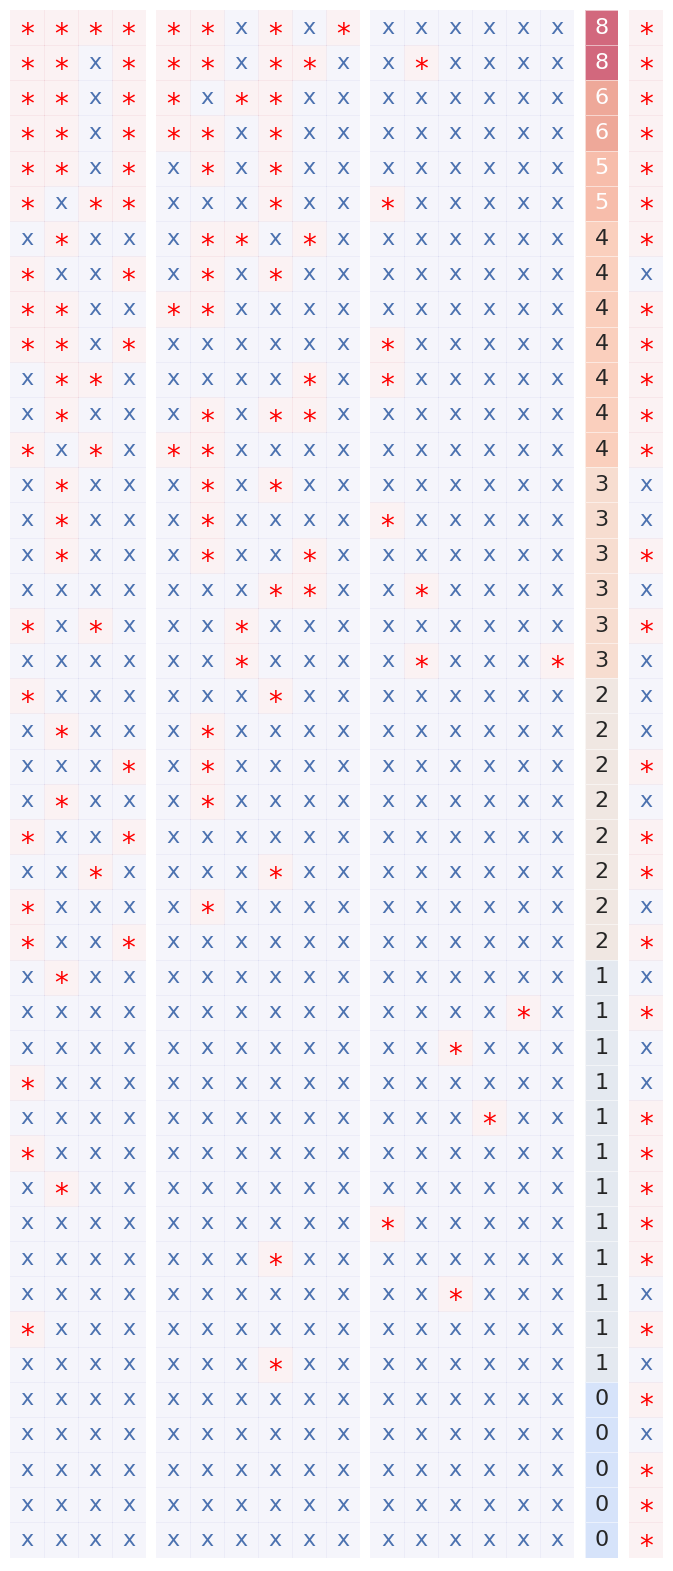

In [21]:
data = df.groupby(['cohort', 'concept']).apply(lambda x:(x['p_value'] < 0.05).sum()).reset_index()
data = pd.pivot_table(data, values = 0, columns = 'cohort', index = 'concept')

larger_group = size_map[size_map == 'larger'].index.tolist()
medium_group = size_map[size_map == 'medium'].index.tolist()
small_group = size_map[size_map == 'small'].index.tolist()
all_group = ['All']
cancer_group = ['BLCA', 'SKCM', 'KIRC', 'LUAD','STAD', 'GBM', 'LUSC']

sum = data[larger_group + medium_group + small_group].sum(axis=1).sort_values(ascending=False)
order = sum.index

# order = CONCEPT.groupby(['BroadCelltypePathway', 'Concept_index']).size().reset_index().sort_values('Concept_index').BroadCelltypePathway.tolist()
# order.append('CANCER')

data = data.loc[order]
data['Sum'] = sum
sum_group = ['Sum']

groups = [larger_group, medium_group, small_group, sum_group, all_group]

fig, axes = plt.subplots(ncols=5, figsize = (7, 16), 
                         sharex=False, sharey=True, 
                         gridspec_kw={'width_ratios': [len(larger_group), len(medium_group), len(small_group), len(sum_group), len(all_group)]})

for group, ax in zip(groups, axes):

    data1 = data[group]

    if group != sum_group:
    # 使用seaborn绘制heatmap
        sns.heatmap(data1, annot=False, cmap='coolwarm', alpha = 0.05, cbar=False, linewidths=.5, ax=ax)
    
        # 在每个单元格中添加*或x
        for i in range(data1.shape[0]):
            for j in range(data1.shape[1]):
                symbol = '*' if data1.iloc[i, j] == 1 else 'x'
                color = 'red' if data1.iloc[i, j] == 1 else 'b'
                fontsize = 20 if data1.iloc[i, j] == 1 else 16
                y_offset = 0.2 if symbol == '*' else 0
                ax.text(j + 0.5, i + 0.5 + y_offset, symbol, ha='center', va='center', color=color, fontsize=fontsize)


    else:
        sns.heatmap(data1, annot=True, cmap='coolwarm', alpha = 0.6, cbar=False, linewidths=.5, ax=ax, vmin = -5, annot_kws=dict(fontsize = 16))

    # ax.set_xticklabels(group, rotation=90)
    # ax.set_ylabel(None)
    # ax.set_xlabel(None)
    # #ax.xaxis.tick_top()

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout(w_pad = 0.5)#
fig.savefig('./cohort_sig_to_response_ordered.svg',bbox_inches ='tight')
pd.Series(order).to_csv('cohort_sig_to_response_ordered.tsv',sep='\t')

In [22]:
pd.Series(order)

0               Macrophage
1          Exhausted_Tcell
2       Cell_proliferation
3          Cytotoxic_Tcell
4             IFNg_pathway
5             TGFb_pathway
6                CD4_Tcell
7                CD8_Tcell
8                   NKcell
9                 Monocyte
10            Memory_Tcell
11       Immune_checkpoint
12        Genome_integrity
13            Memory_Bcell
14           Tcell_general
15                     pDC
16             Erythrocyte
17              Epithelial
18             Granulocyte
19              Pancreatic
20             Plasma_cell
21           Bcell_general
22                  Stroma
23                 Myeloid
24                Cytokine
25                Platelet
26                Pericyte
27                    Treg
28                     TLS
29                    Stem
30               Reference
31              Pneumocyte
32              Hepatocyte
33             Naive_Bcell
34             Endothelial
35             Mesothelial
36       Apoptosis_pathway
3

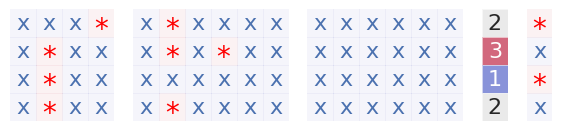

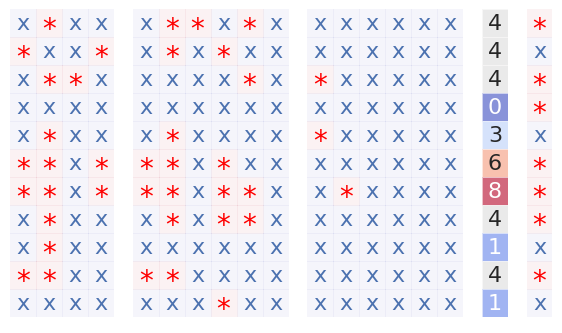

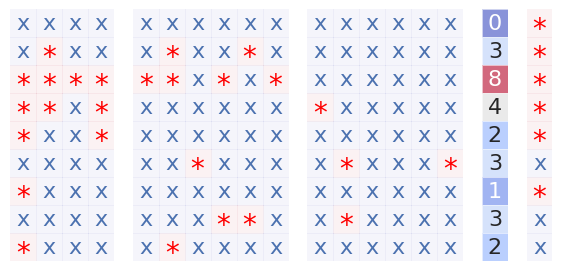

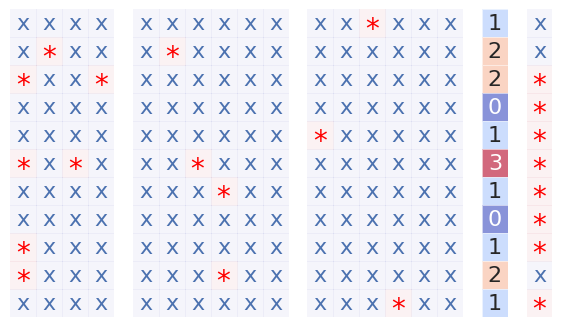

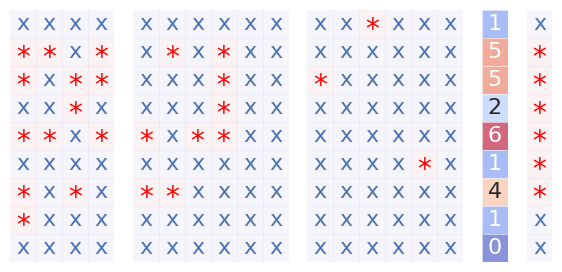

In [23]:
data = df.groupby(['cohort', 'concept']).apply(lambda x:(x['p_value'] < 0.05).sum()).reset_index()
data = pd.pivot_table(data, values = 0, columns = 'cohort', index = 'concept')

larger_group = size_map[size_map == 'larger'].index.tolist()
medium_group = size_map[size_map == 'medium'].index.tolist()
small_group = size_map[size_map == 'small'].index.tolist()
all_group = ['All']
cancer_group = ['BLCA', 'SKCM', 'KIRC', 'LUAD','STAD', 'GBM', 'LUSC']

sum = data[larger_group + medium_group + small_group].sum(axis=1).sort_values(ascending=False)
order = sum.index

order = CONCEPT.groupby(['BroadCelltypePathway', 'Concept_index']).size().reset_index().sort_values('Concept_index').BroadCelltypePathway.tolist()
order.append('CANCER')

data = data.loc[order]
data['Sum'] = sum
sum_group = ['Sum']

groups = [larger_group, medium_group, small_group, sum_group, all_group]

lin = data.index.map(Lineage_map)

for l in ['Lymphoid_lineage_Bcell', 'Lymphoid_lineage_T/NKcell',
       'Myeloid_lineage', 'Mesenchymal_lineage', 'Functional_group']:

    myl = lin == l

    fig, axes = plt.subplots(ncols=5, figsize = (7, (16/44)*myl.sum()), 
                             sharex=False, sharey=True, 
                             gridspec_kw={'width_ratios': [len(larger_group), len(medium_group), len(small_group), len(sum_group), len(all_group)]})
    
    for group, ax in zip(groups, axes):
    
        data1 = data[group][myl]
    
        if group != sum_group:
        # 使用seaborn绘制heatmap
            sns.heatmap(data1, annot=False, cmap='coolwarm', alpha = 0.05, cbar=False, linewidths=.5, ax=ax)
        
            # 在每个单元格中添加*或x
            for i in range(data1.shape[0]):
                for j in range(data1.shape[1]):
                    symbol = '*' if data1.iloc[i, j] == 1 else 'x'
                    color = 'red' if data1.iloc[i, j] == 1 else 'b'
                    fontsize = 20 if data1.iloc[i, j] == 1 else 16
                    y_offset = 0.2 if symbol == '*' else 0
                    ax.text(j + 0.5, i + 0.5 + y_offset, symbol, ha='center', va='center', color=color, fontsize=fontsize)
    
    
        else:
            sns.heatmap(data1, annot=True, cmap='coolwarm', alpha = 0.6,   cbar=False, linewidths=.5, ax=ax, annot_kws=dict(fontsize = 16))
    
        # ax.set_xticklabels(group, rotation=90)
        # ax.set_ylabel(None)
        # ax.set_xlabel(None)
        #ax.xaxis.tick_top()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    #plt.tight_layout(w_pad = 0.5)#
    fig.savefig('./cohort_sig_to_response_%s.svg' % l.replace('/','_'), bbox_inches ='tight')


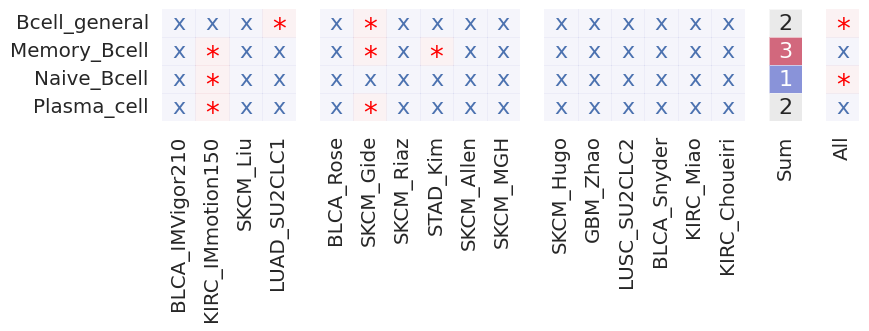

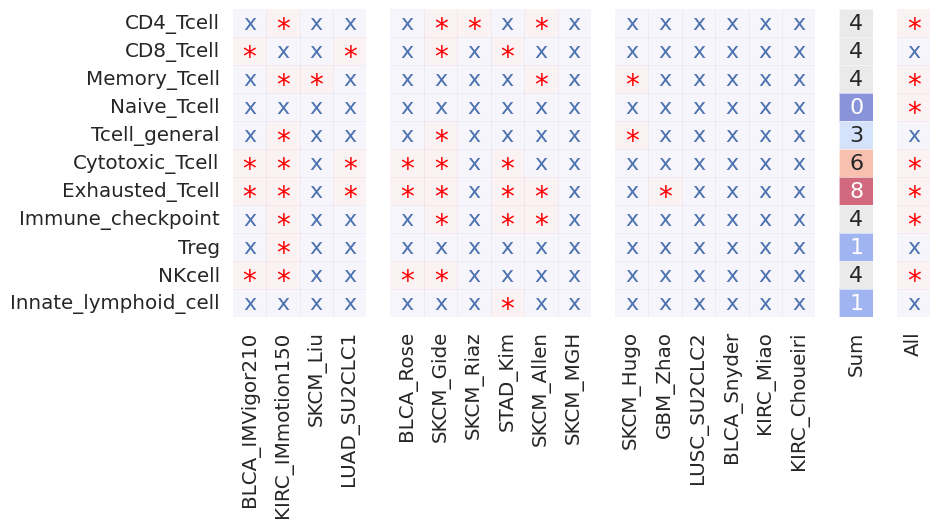

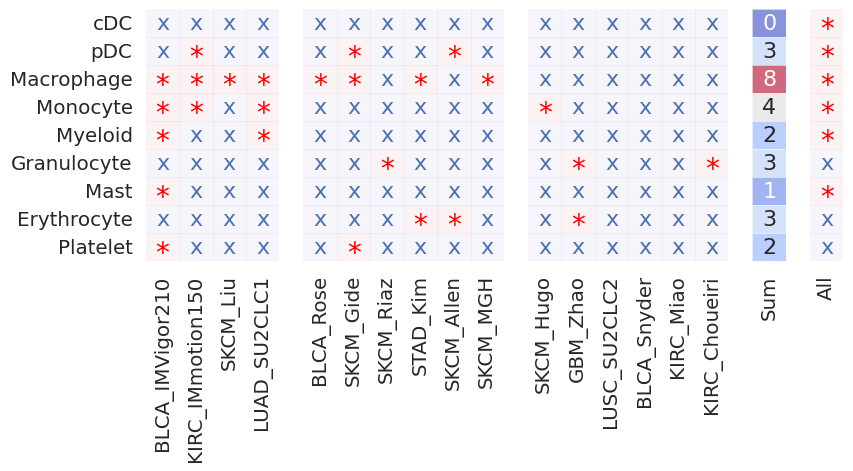

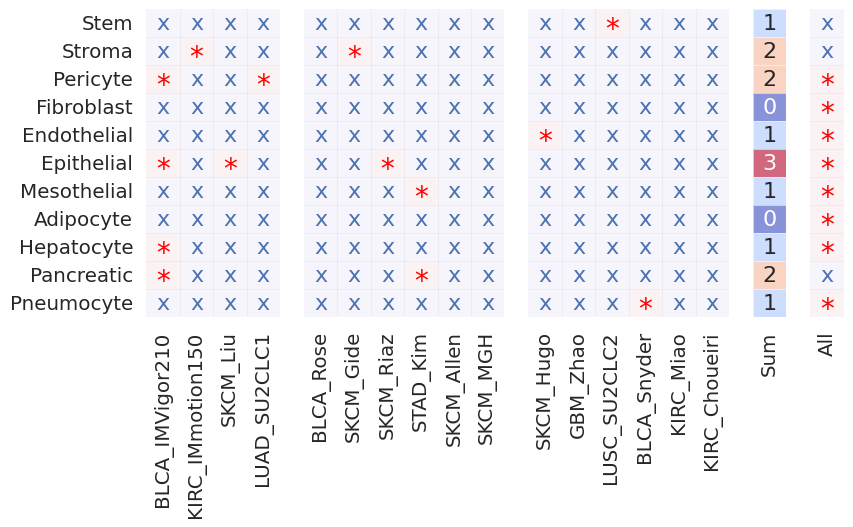

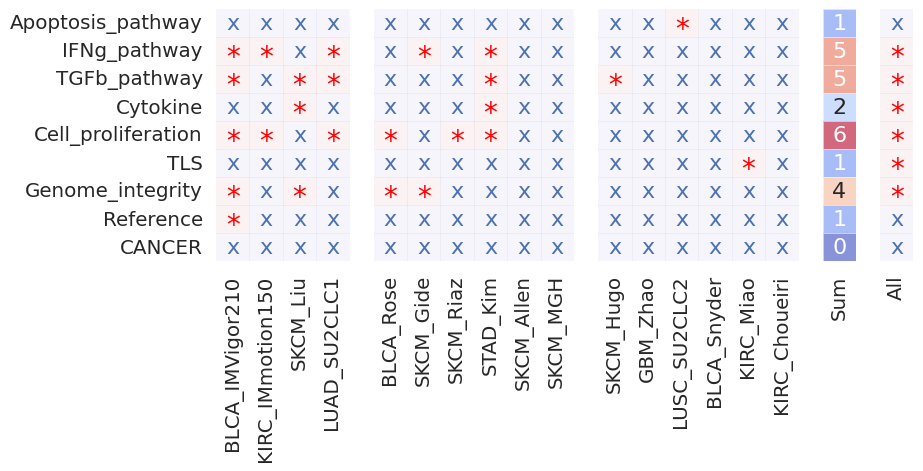

In [24]:
data = df.groupby(['cohort', 'concept']).apply(lambda x:(x['p_value'] < 0.05).sum()).reset_index()
data = pd.pivot_table(data, values = 0, columns = 'cohort', index = 'concept')

larger_group = size_map[size_map == 'larger'].index.tolist()
medium_group = size_map[size_map == 'medium'].index.tolist()
small_group = size_map[size_map == 'small'].index.tolist()
all_group = ['All']
cancer_group = ['BLCA', 'SKCM', 'KIRC', 'LUAD','STAD', 'GBM', 'LUSC']

sum = data[larger_group + medium_group + small_group].sum(axis=1).sort_values(ascending=False)
order = sum.index

order = CONCEPT.groupby(['BroadCelltypePathway', 'Concept_index']).size().reset_index().sort_values('Concept_index').BroadCelltypePathway.tolist()
order.append('CANCER')

data = data.loc[order]
data['Sum'] = sum
sum_group = ['Sum']

groups = [larger_group, medium_group, small_group, sum_group, all_group]

lin = data.index.map(Lineage_map)

for l in ['Lymphoid_lineage_Bcell', 'Lymphoid_lineage_T/NKcell',
       'Myeloid_lineage', 'Mesenchymal_lineage', 'Functional_group']:

    myl = lin == l

    fig, axes = plt.subplots(ncols=5, figsize = (9, (16/44)*myl.sum()), 
                             sharex=False, sharey=True, 
                             gridspec_kw={'width_ratios': [len(larger_group), len(medium_group), len(small_group), len(sum_group), len(all_group)]})
    
    for group, ax in zip(groups, axes):
    
        data1 = data[group][myl]
    
        if group != sum_group:
        # 使用seaborn绘制heatmap
            sns.heatmap(data1, annot=False, cmap='coolwarm', alpha = 0.05, cbar=False, linewidths=.5, ax=ax)
        
            # 在每个单元格中添加*或x
            for i in range(data1.shape[0]):
                for j in range(data1.shape[1]):
                    symbol = '*' if data1.iloc[i, j] == 1 else 'x'
                    color = 'red' if data1.iloc[i, j] == 1 else 'b'
                    fontsize = 20 if data1.iloc[i, j] == 1 else 16
                    y_offset = 0.2 if symbol == '*' else 0
                    ax.text(j + 0.5, i + 0.5 + y_offset, symbol, ha='center', va='center', color=color, fontsize=fontsize)
    
        else:
            sns.heatmap(data1, annot=True, cmap='coolwarm', alpha = 0.6,   cbar=False, linewidths=.5, ax=ax, annot_kws=dict(fontsize = 16))
    
        ax.set_xticklabels(group, rotation=90)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        #ax.xaxis.tick_top()

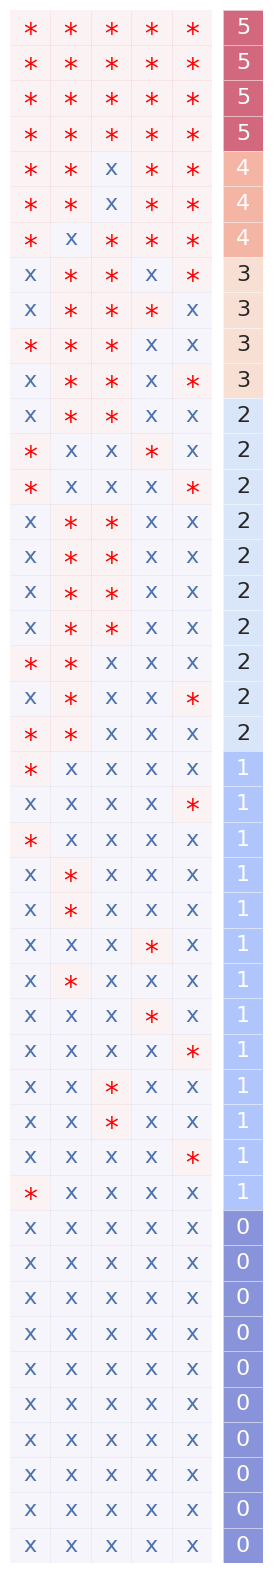

In [33]:
data = df.groupby(['cohort', 'concept']).apply(lambda x:(x['p_value'] < 0.05).sum()).reset_index()
data = pd.pivot_table(data, values = 0, columns = 'cohort', index = 'concept')

larger_group = size_map[size_map == 'larger'].index.tolist()
medium_group = size_map[size_map == 'medium'].index.tolist()
small_group = size_map[size_map == 'small'].index.tolist()
all_group = ['All']
cancer_group = ['BLCA', 'SKCM', 'KIRC', 'LUAD','STAD', ] #'GBM', 'LUSC'

sum = data[cancer_group].sum(axis=1).sort_values(ascending=False)
order = sum.index

# order = CONCEPT.groupby(['BroadCelltypePathway', 'Concept_index']).size().reset_index().sort_values('Concept_index').BroadCelltypePathway.tolist()
# order.append('CANCER')

data = data.loc[order]
data['Sum'] = sum
sum_group = ['Sum']

fig, axes = plt.subplots(ncols=2, figsize = (6*0.5, 16), 
                         sharex=False, sharey=True, 
                         gridspec_kw={'width_ratios': [len(cancer_group), len(sum_group),]})

for group, ax in zip([cancer_group, sum_group, ], axes):

    data1 = data[group]

    if group != sum_group:
    # 使用seaborn绘制heatmap
        sns.heatmap(data1, annot=False, cmap='coolwarm', alpha = 0.05, cbar=False, linewidths=.5, ax=ax)
    
        # 在每个单元格中添加*或x
        for i in range(data1.shape[0]):
            for j in range(data1.shape[1]):
                symbol = '*' if data1.iloc[i, j] == 1 else 'x'
                color = 'red' if data1.iloc[i, j] == 1 else 'b'
                fontsize = 20 if data1.iloc[i, j] == 1 else 16
                y_offset = 0.2 if symbol == '*' else 0
                ax.text(j + 0.5, i + 0.5 + y_offset, symbol, ha='center', va='center', color=color, fontsize=fontsize)


    else:
        sns.heatmap(data1, annot=True, cmap='coolwarm', alpha = 0.6,   cbar=False, linewidths=.5, ax=ax, annot_kws=dict(fontsize = 16))

    ax.set_xticklabels(group, rotation=90)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    #ax.xaxis.tick_top()


    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.tight_layout(w_pad = 0.5)
fig.savefig('./cancer_sig_to_response.svg',bbox_inches ='tight')
pd.Series(order).to_csv('cancer_sig_to_response.tsv',sep='\t')

Text(236.25, 0.5, 'Cohort')

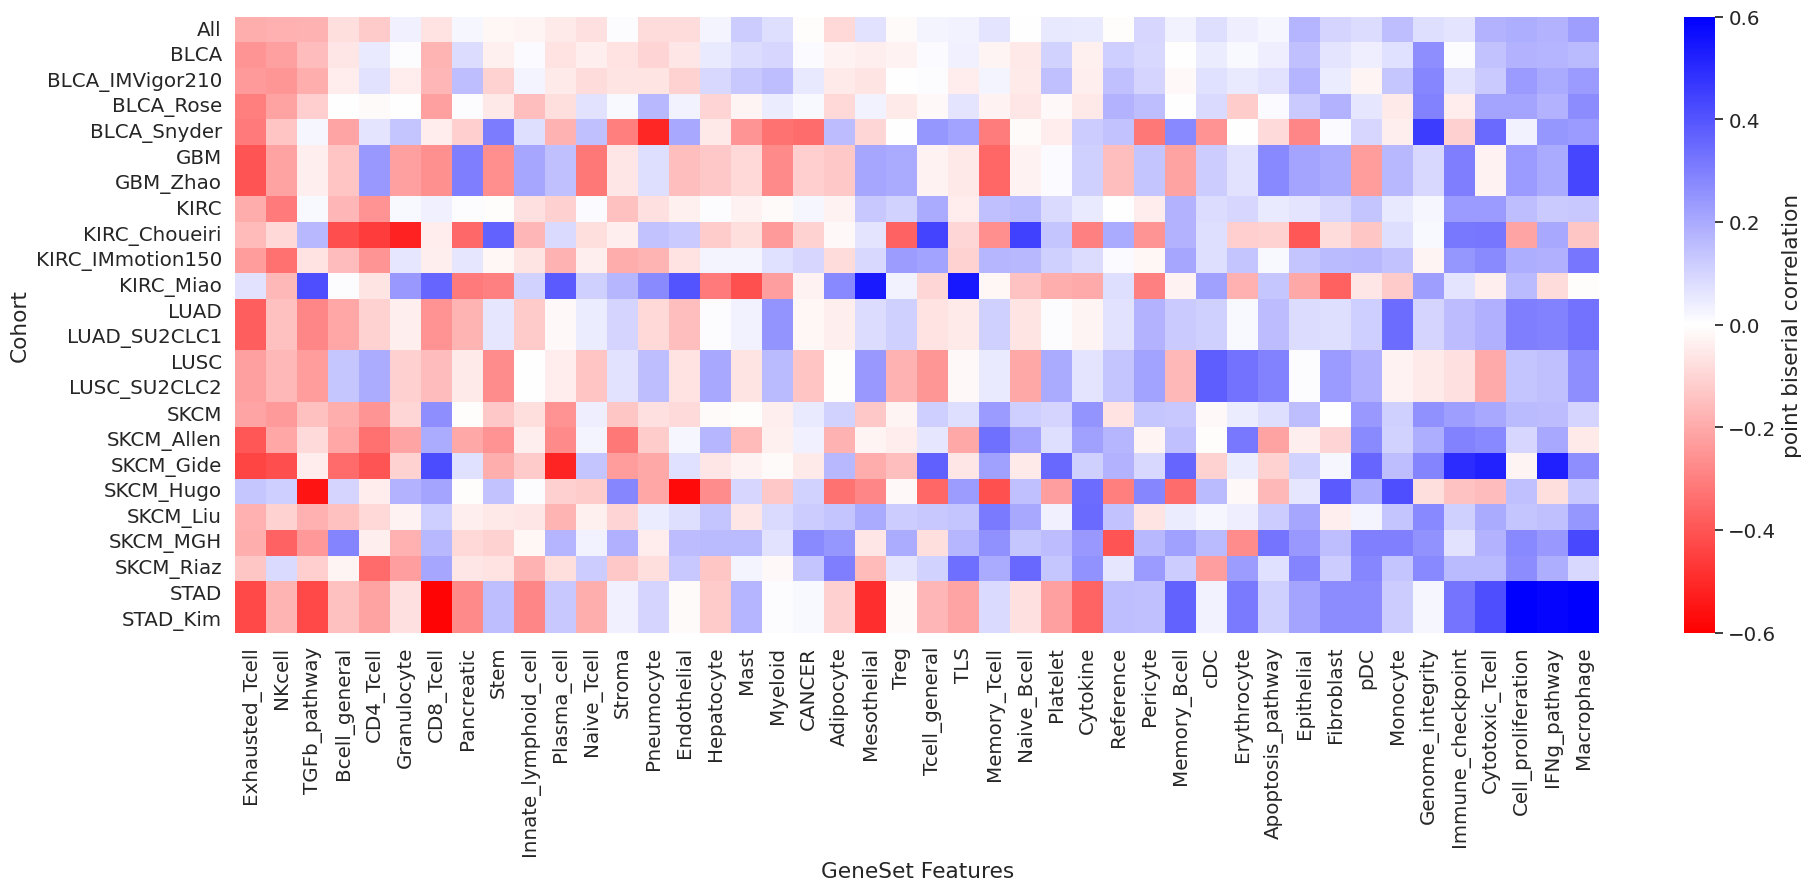

In [34]:
df_gfc = pd.pivot_table(df, columns='concept', index='cohort', values = 'pbc')
order = df_gfc.mean().sort_values().index
df_gfc = df_gfc[order]
fig, ax = plt.subplots(figsize = (22,8))
sns.heatmap(df_gfc, cmap = 'bwr_r', ax=ax, cbar_kws={'label': 'point biserial correlation'}, vmin = -0.6, vmax=0.6) # 

ax.set_xlabel('GeneSet Features')
ax.set_ylabel('Cohort')

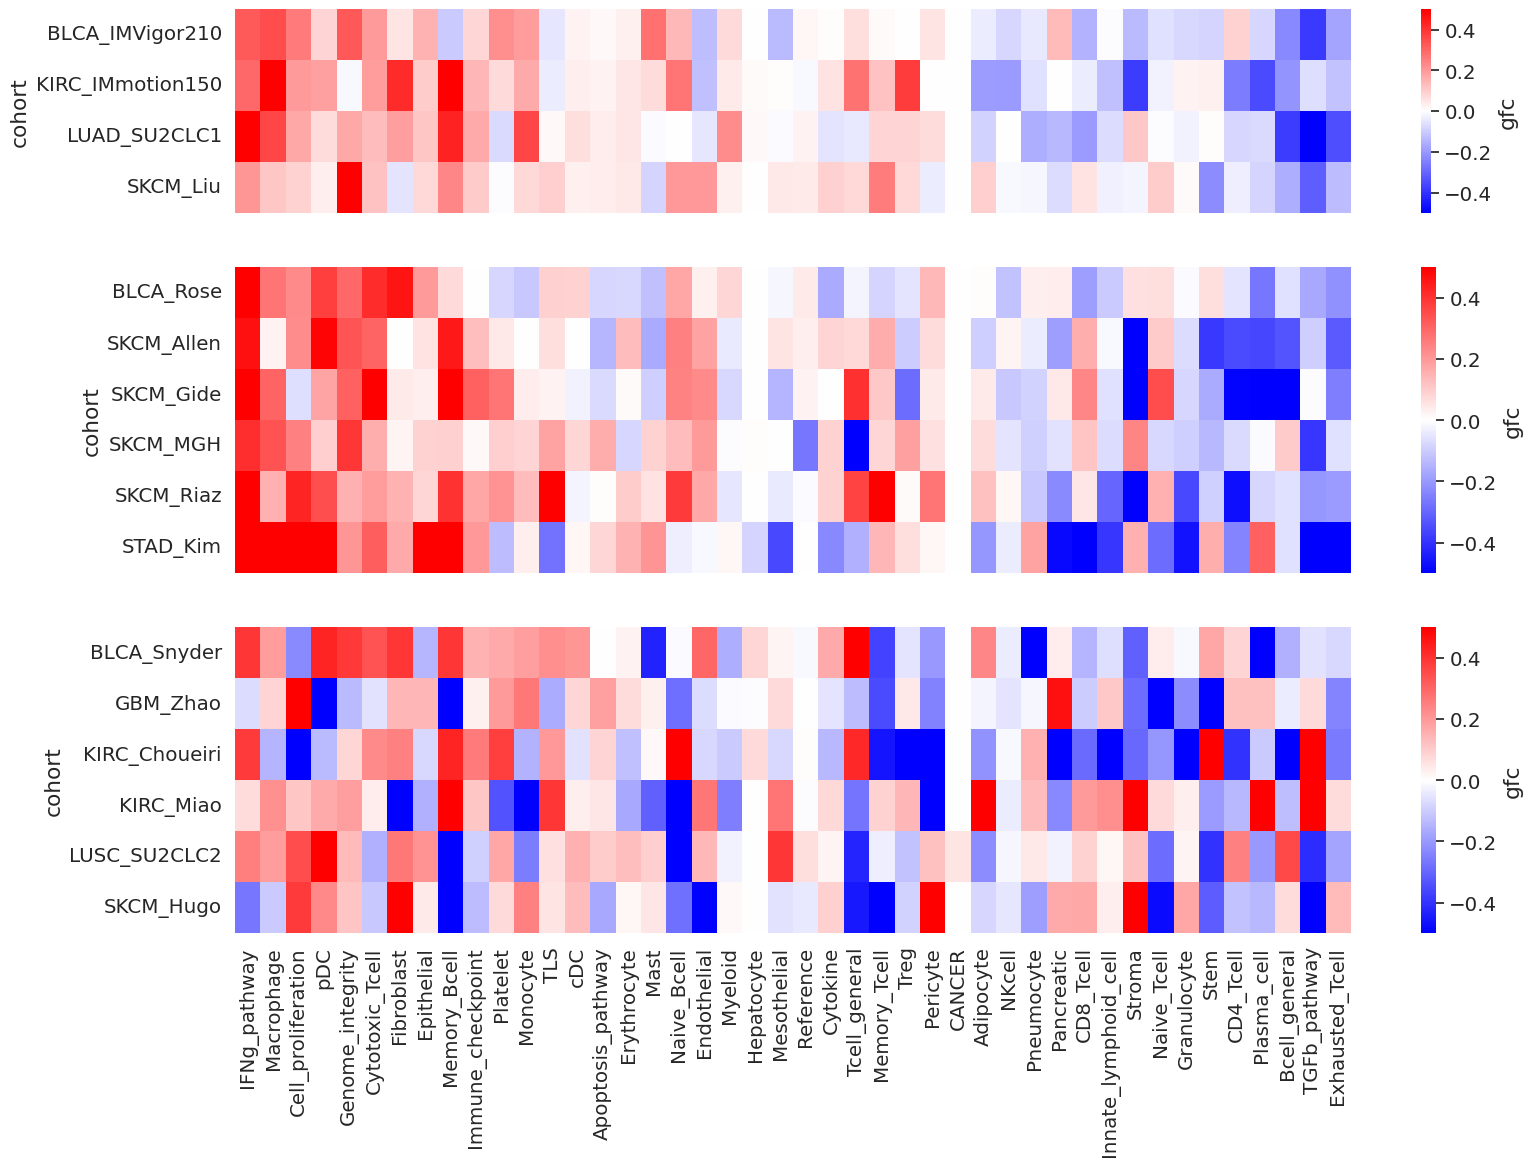

In [35]:
values = 'gfc'
df_gfc = pd.pivot_table(df, columns='concept', index='cohort', values = values)
order = df_gfc.mean().sort_values(ascending=False).index
df_gfc = df_gfc[order]

fig, axes = plt.subplots(nrows=3, figsize = (18,0.5*len(df_gfc)), sharex=True, gridspec_kw={'height_ratios': [4, 6, 6]})

ax1, ax2, ax3 = axes


scohort = size_map[size_map=='larger'].index
dfp = df_gfc[df_gfc.index.isin(scohort)]
sns.heatmap(dfp, cmap = 'bwr', ax=ax1, cbar_kws={'label': values}, vmin = -0.5, vmax=0.5) # 


scohort = size_map[size_map=='medium'].index
dfp = df_gfc[df_gfc.index.isin(scohort)]
sns.heatmap(dfp, cmap = 'bwr', ax=ax2, cbar_kws={'label': values}, vmin = -0.5, vmax=0.5) # 


scohort = size_map[size_map=='small'].index
dfp = df_gfc[df_gfc.index.isin(scohort)]
sns.heatmap(dfp, cmap = 'bwr', ax=ax3, cbar_kws={'label': values}, vmin = -0.5, vmax=0.5) # 


for ax in axes:
    ax.set_xlabel('')


In [36]:
cancer_group

['BLCA', 'SKCM', 'KIRC', 'LUAD', 'STAD']

### gfc bar large cohort

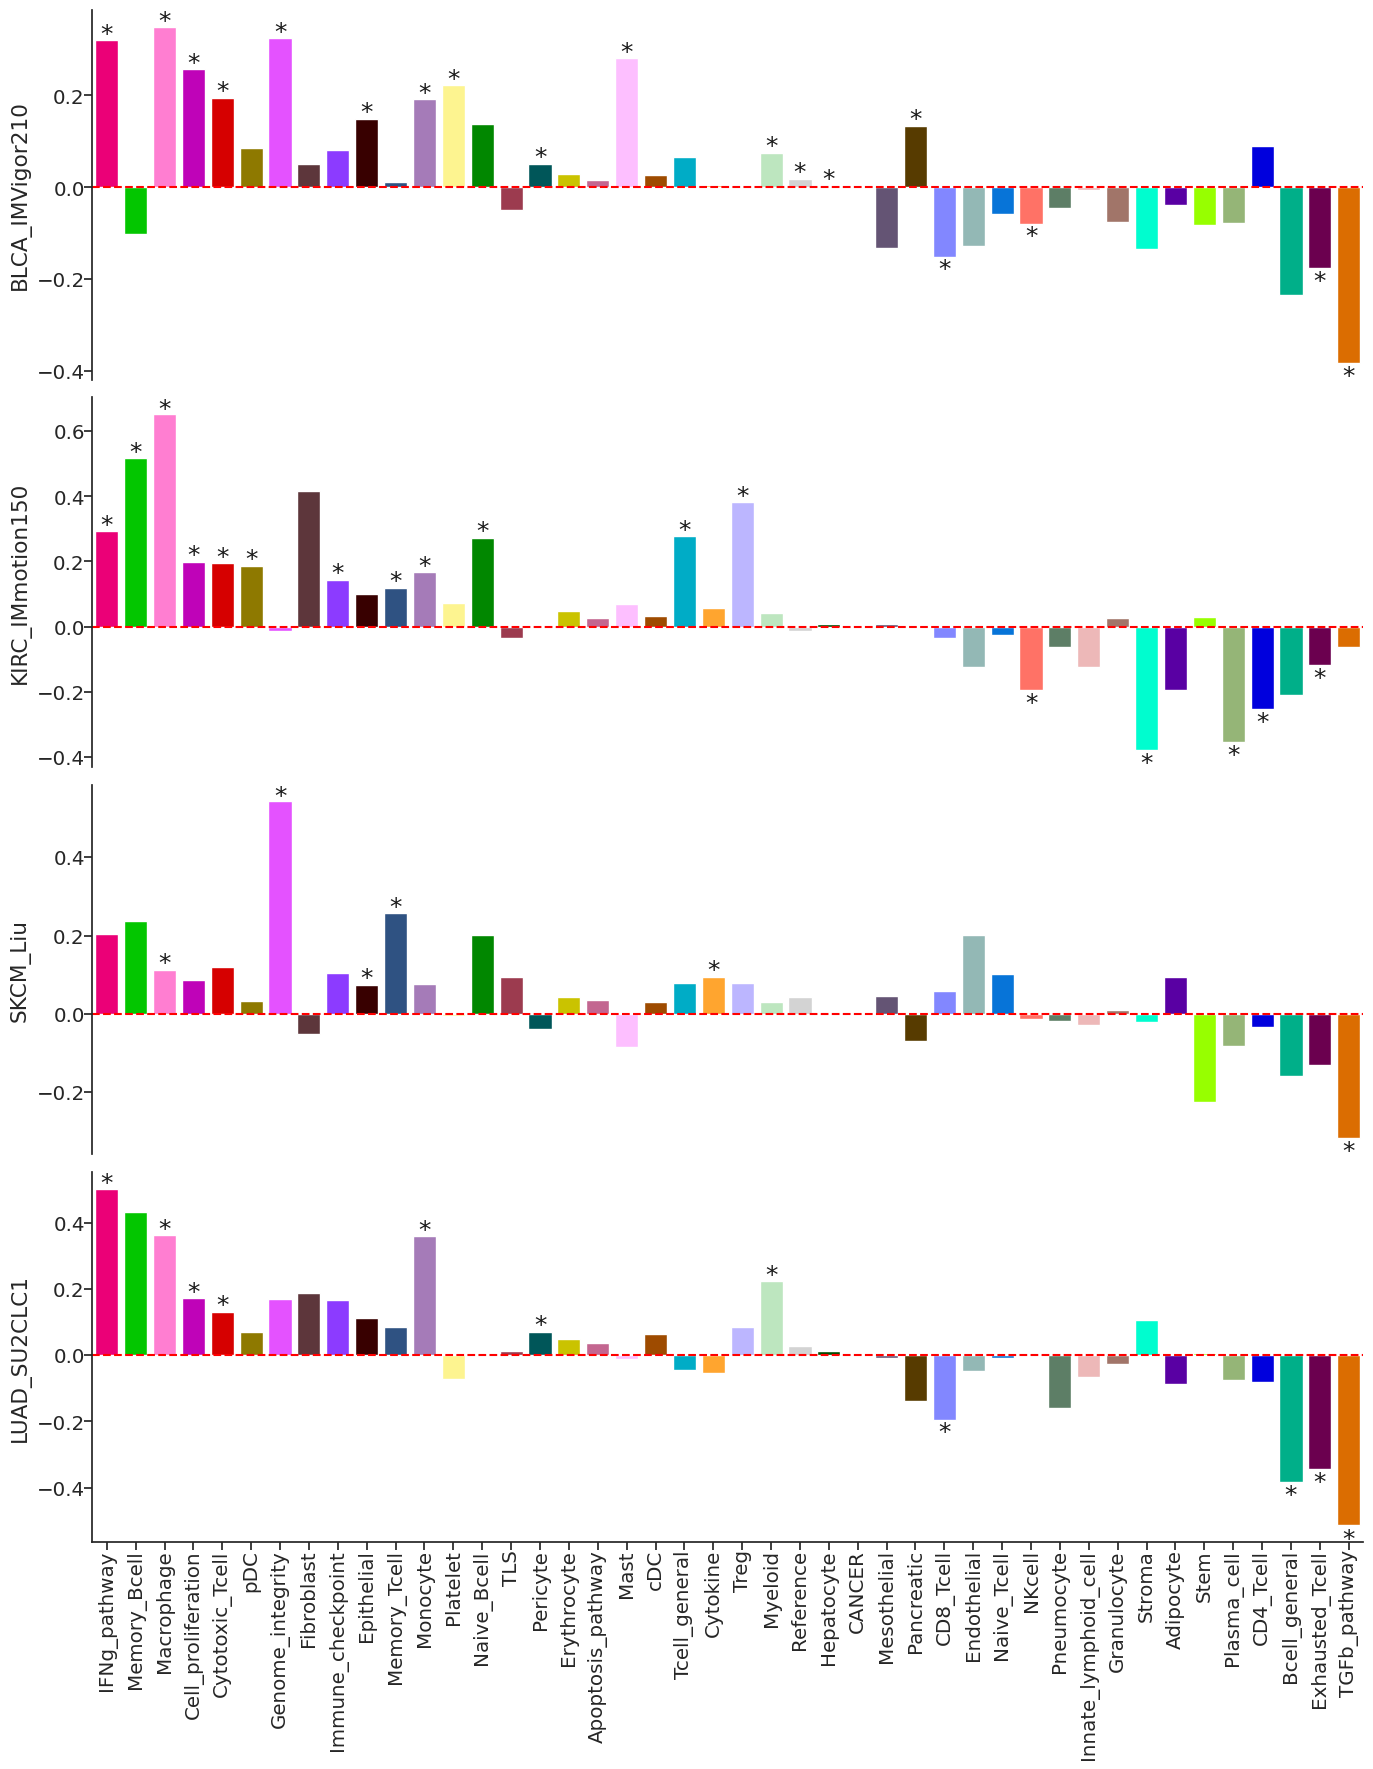

In [37]:
fc = 'gfc'
p = 'p_value'

df1 = df[[fc, p, 'concept', 'cohort', 'Lineage_order']]

order = df1.groupby('concept')[fc].median().sort_values(ascending=False).index

scohort = size_map[size_map=='larger'].index
df1 = df1[df1.cohort.isin(scohort)]




# order_df = df1.groupby('concept')[fc].mean().to_frame(name = 'mean')
# order_df['l_order'] = -order_df.index.map(concept_lin_order)
# order = order_df.sort_values(['l_order', 'mean'], ascending=False).index

# order = CONCEPT.groupby(['BroadCelltypePathway', 'Concept_index']).size().reset_index().sort_values('Concept_index').BroadCelltypePathway.tolist()
# order.append('CANCER')

# 定义特征颜色
feature_color = CONCEPT_palette

# 假设数据有 'cohort', 'concept', 'gfc', 'p_value' 列
#cohorts = size_map.index #df1['cohort'].unique()

# 创建16个子图
fig, axes = plt.subplots(nrows=len(scohort), figsize = (14, len(scohort)*4.5), sharex=True)

for i, cohort in enumerate(scohort):  # 确保只有16个子图

    #fig, ax = plt.subplots(figsize=(10, 4), sharex=False, sharey=False)
    ax = axes[i]

    cohort_data = df1[df1['cohort'] == cohort]
    
    # 按照gfc排序
    #cohort_data = cohort_data.sort_values(by=fc)
    cohort_data = cohort_data.set_index('concept').loc[order].reset_index()
    
    # 绘制散点图
    for index, row in cohort_data.iterrows():
        
        bar = ax.bar(row['concept'], row[fc], color=feature_color.get(row['concept'], '#000000'), ) #marker=shape, s=100
        if row[p] < 0.05:
            height = bar[0].get_height()
            if height > 0:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height-height/100),
                            ha='center', fontsize=18, color='k')
            else:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height+height/100),
                            ha='center',va='top', fontsize=18, color='k')
                
    # 红色虚线表示gfc为0的情况
    ax.axhline(0, color='red', linestyle='--')
    
    ax.set_ylabel(cohort)
    ax.set_xlim(-0.5, len(cohort_data) - 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

    if i == len(scohort)-1:
        ax.tick_params(axis='both', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        ax.set_xticklabels(order, rotation=90)

    else:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='y', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        # ax.set_xticklabels([])
        # ax.set_xticks(range(len(cohort_data)))
        ax.set_xticklabels([])
        
        #ax.set_ylim(-abs(cohort_data[fc].min())+0.1, cohort_data[fc].max()-0.02)
    # 调整布局

plt.tight_layout(h_pad=0.1)
plt.show()

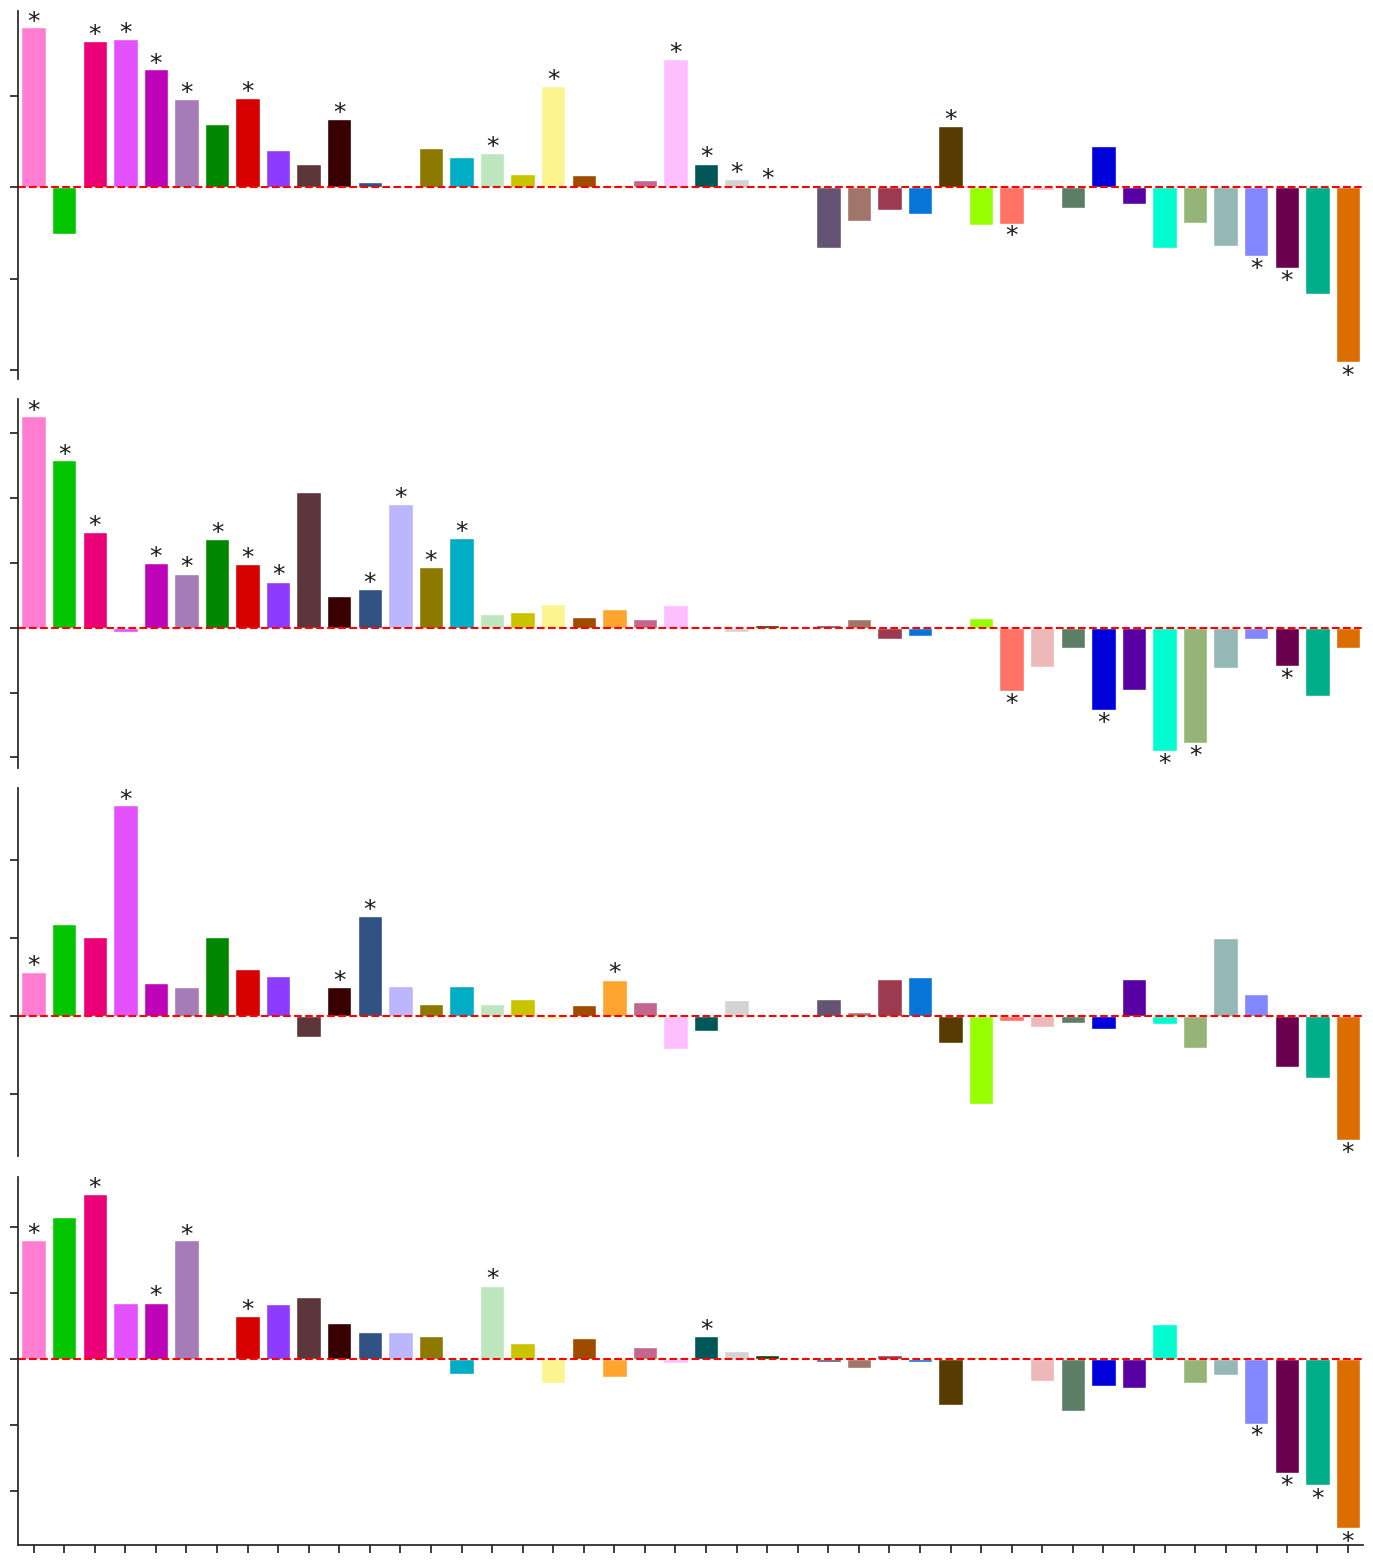

In [38]:
df1 = df[[fc, p, 'concept', 'cohort', 'Lineage_order']]


scohort = size_map[size_map=='larger'].index
df1 = df1[df1.cohort.isin(scohort)]


order = df1.groupby('concept')[fc].median().sort_values(ascending=False).index


# order_df = df1.groupby('concept')[fc].mean().to_frame(name = 'mean')
# order_df['l_order'] = -order_df.index.map(concept_lin_order)
# order = order_df.sort_values(['l_order', 'mean'], ascending=False).index

# order = CONCEPT.groupby(['BroadCelltypePathway', 'Concept_index']).size().reset_index().sort_values('Concept_index').BroadCelltypePathway.tolist()
# order.append('CANCER')

# 定义特征颜色
feature_color = CONCEPT_palette

# 假设数据有 'cohort', 'concept', 'gfc', 'p_value' 列
#cohorts = size_map.index #df1['cohort'].unique()

# 创建16个子图
fig, axes = plt.subplots(nrows=len(scohort), figsize = (14, len(scohort)*4.), sharex=True)

for i, cohort in enumerate(scohort):  # 确保只有16个子图

    #fig, ax = plt.subplots(figsize=(10, 4), sharex=False, sharey=False)
    ax = axes[i]

    cohort_data = df1[df1['cohort'] == cohort]
    
    # 按照gfc排序
    #cohort_data = cohort_data.sort_values(by=fc)
    cohort_data = cohort_data.set_index('concept').loc[order].reset_index()
    
    # 绘制散点图
    for index, row in cohort_data.iterrows():
        
        bar = ax.bar(row['concept'], row[fc], color=feature_color.get(row['concept'], '#000000'), ) #marker=shape, s=100
        if row[p] < 0.05:
            height = bar[0].get_height()
            if height > 0:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height-height/100),
                            ha='center', fontsize=18, color='k')
            else:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height+height/100),
                            ha='center',va='top', fontsize=18, color='k')
                
    # 红色虚线表示gfc为0的情况
    ax.axhline(0, color='red', linestyle='--')
    
    ax.set_ylabel(cohort)
    ax.set_xlim(-0.5, len(cohort_data) - 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

    if i == len(scohort)-1:
        ax.tick_params(axis='both', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        ax.set_xticklabels(order, rotation=90)

    else:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='y', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)

        # ax.set_xticks(range(len(cohort_data)))
        ax.set_xticklabels([])
        
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylabel(None)


plt.tight_layout(h_pad=0.1)
fig.savefig('./gfc_bar_large_cohort.svg',bbox_inches ='tight')
pd.Series(index=order).to_csv('gfc_bar_large_cohort_order.tsv',sep='\t')

### pbc bar medium/small cohort

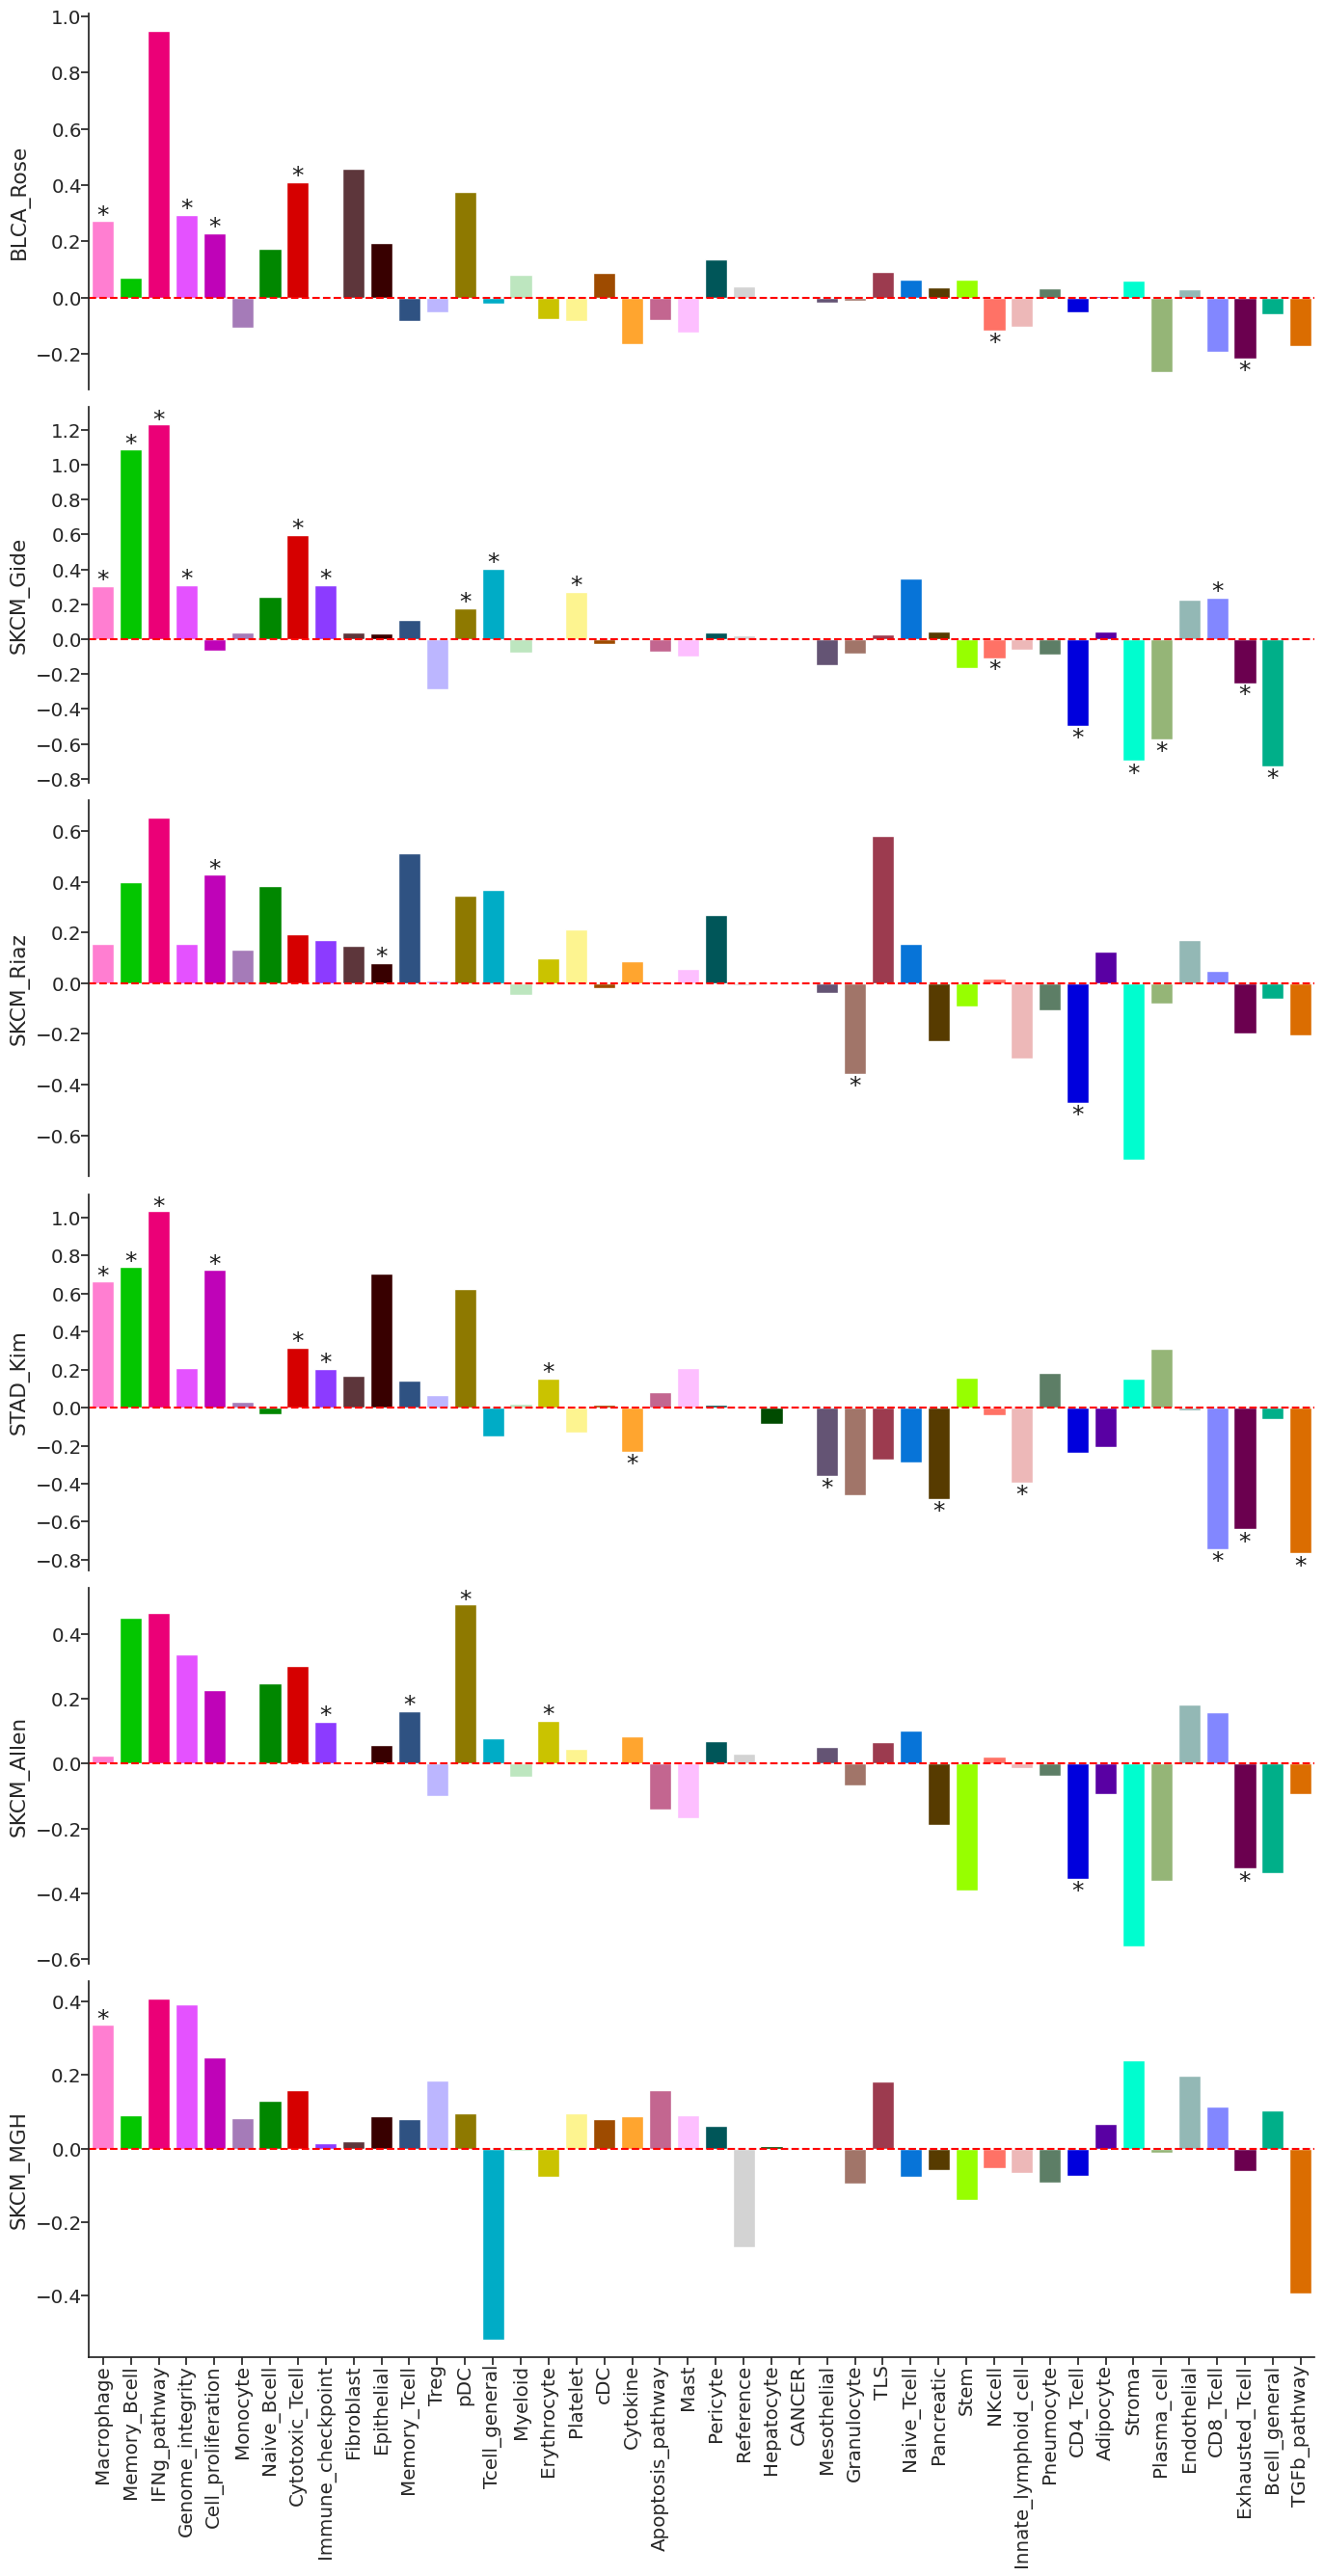

In [39]:
scohort = size_map[size_map=='medium'].index
df1 = df[df.cohort.isin(scohort)]

feature_color = CONCEPT_palette

# 假设数据有 'cohort', 'concept', 'gfc', 'p_value' 列
#cohorts = size_map.index #df1['cohort'].unique()

# 创建16个子图
fig, axes = plt.subplots(nrows=len(scohort), figsize = (14, len(scohort)*4.5), sharex=True)

for i, cohort in enumerate(scohort):  # 确保只有16个子图

    #fig, ax = plt.subplots(figsize=(10, 4), sharex=False, sharey=False)
    ax = axes[i]

    cohort_data = df1[df1['cohort'] == cohort]
    
    # 按照gfc排序
    #cohort_data = cohort_data.sort_values(by=fc)
    cohort_data = cohort_data.set_index('concept').loc[order].reset_index()
    
    # 绘制散点图
    for index, row in cohort_data.iterrows():
        
        bar = ax.bar(row['concept'], row[fc], color=feature_color.get(row['concept'], '#000000'), ) #marker=shape, s=100
        if row[p] < 0.05:
            height = bar[0].get_height()
            if height > 0:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height-height/100),
                            ha='center', fontsize=18, color='k')
            else:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height+height/100),
                            ha='center',va='top', fontsize=18, color='k')
                
    # 红色虚线表示gfc为0的情况
    ax.axhline(0, color='red', linestyle='--')
    
    ax.set_ylabel(cohort)
    ax.set_xlim(-0.5, len(cohort_data) - 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

    if i == len(scohort)-1:
        ax.tick_params(axis='both', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        ax.set_xticklabels(order, rotation=90)

    else:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='y', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        # ax.set_xticklabels([])
        # ax.set_xticks(range(len(cohort_data)))
        ax.set_xticklabels([])
        
        #ax.set_ylim(-abs(cohort_data[fc].min())+0.1, cohort_data[fc].max()-0.02)
    # 调整布局

plt.tight_layout(h_pad=0.1)
fig.savefig('./gfc_bar_medium_cohort.svg',bbox_inches ='tight')

In [40]:
scohort

Index(['BLCA_Rose', 'SKCM_Gide', 'SKCM_Riaz', 'STAD_Kim', 'SKCM_Allen',
       'SKCM_MGH'],
      dtype='object', name='cohort')

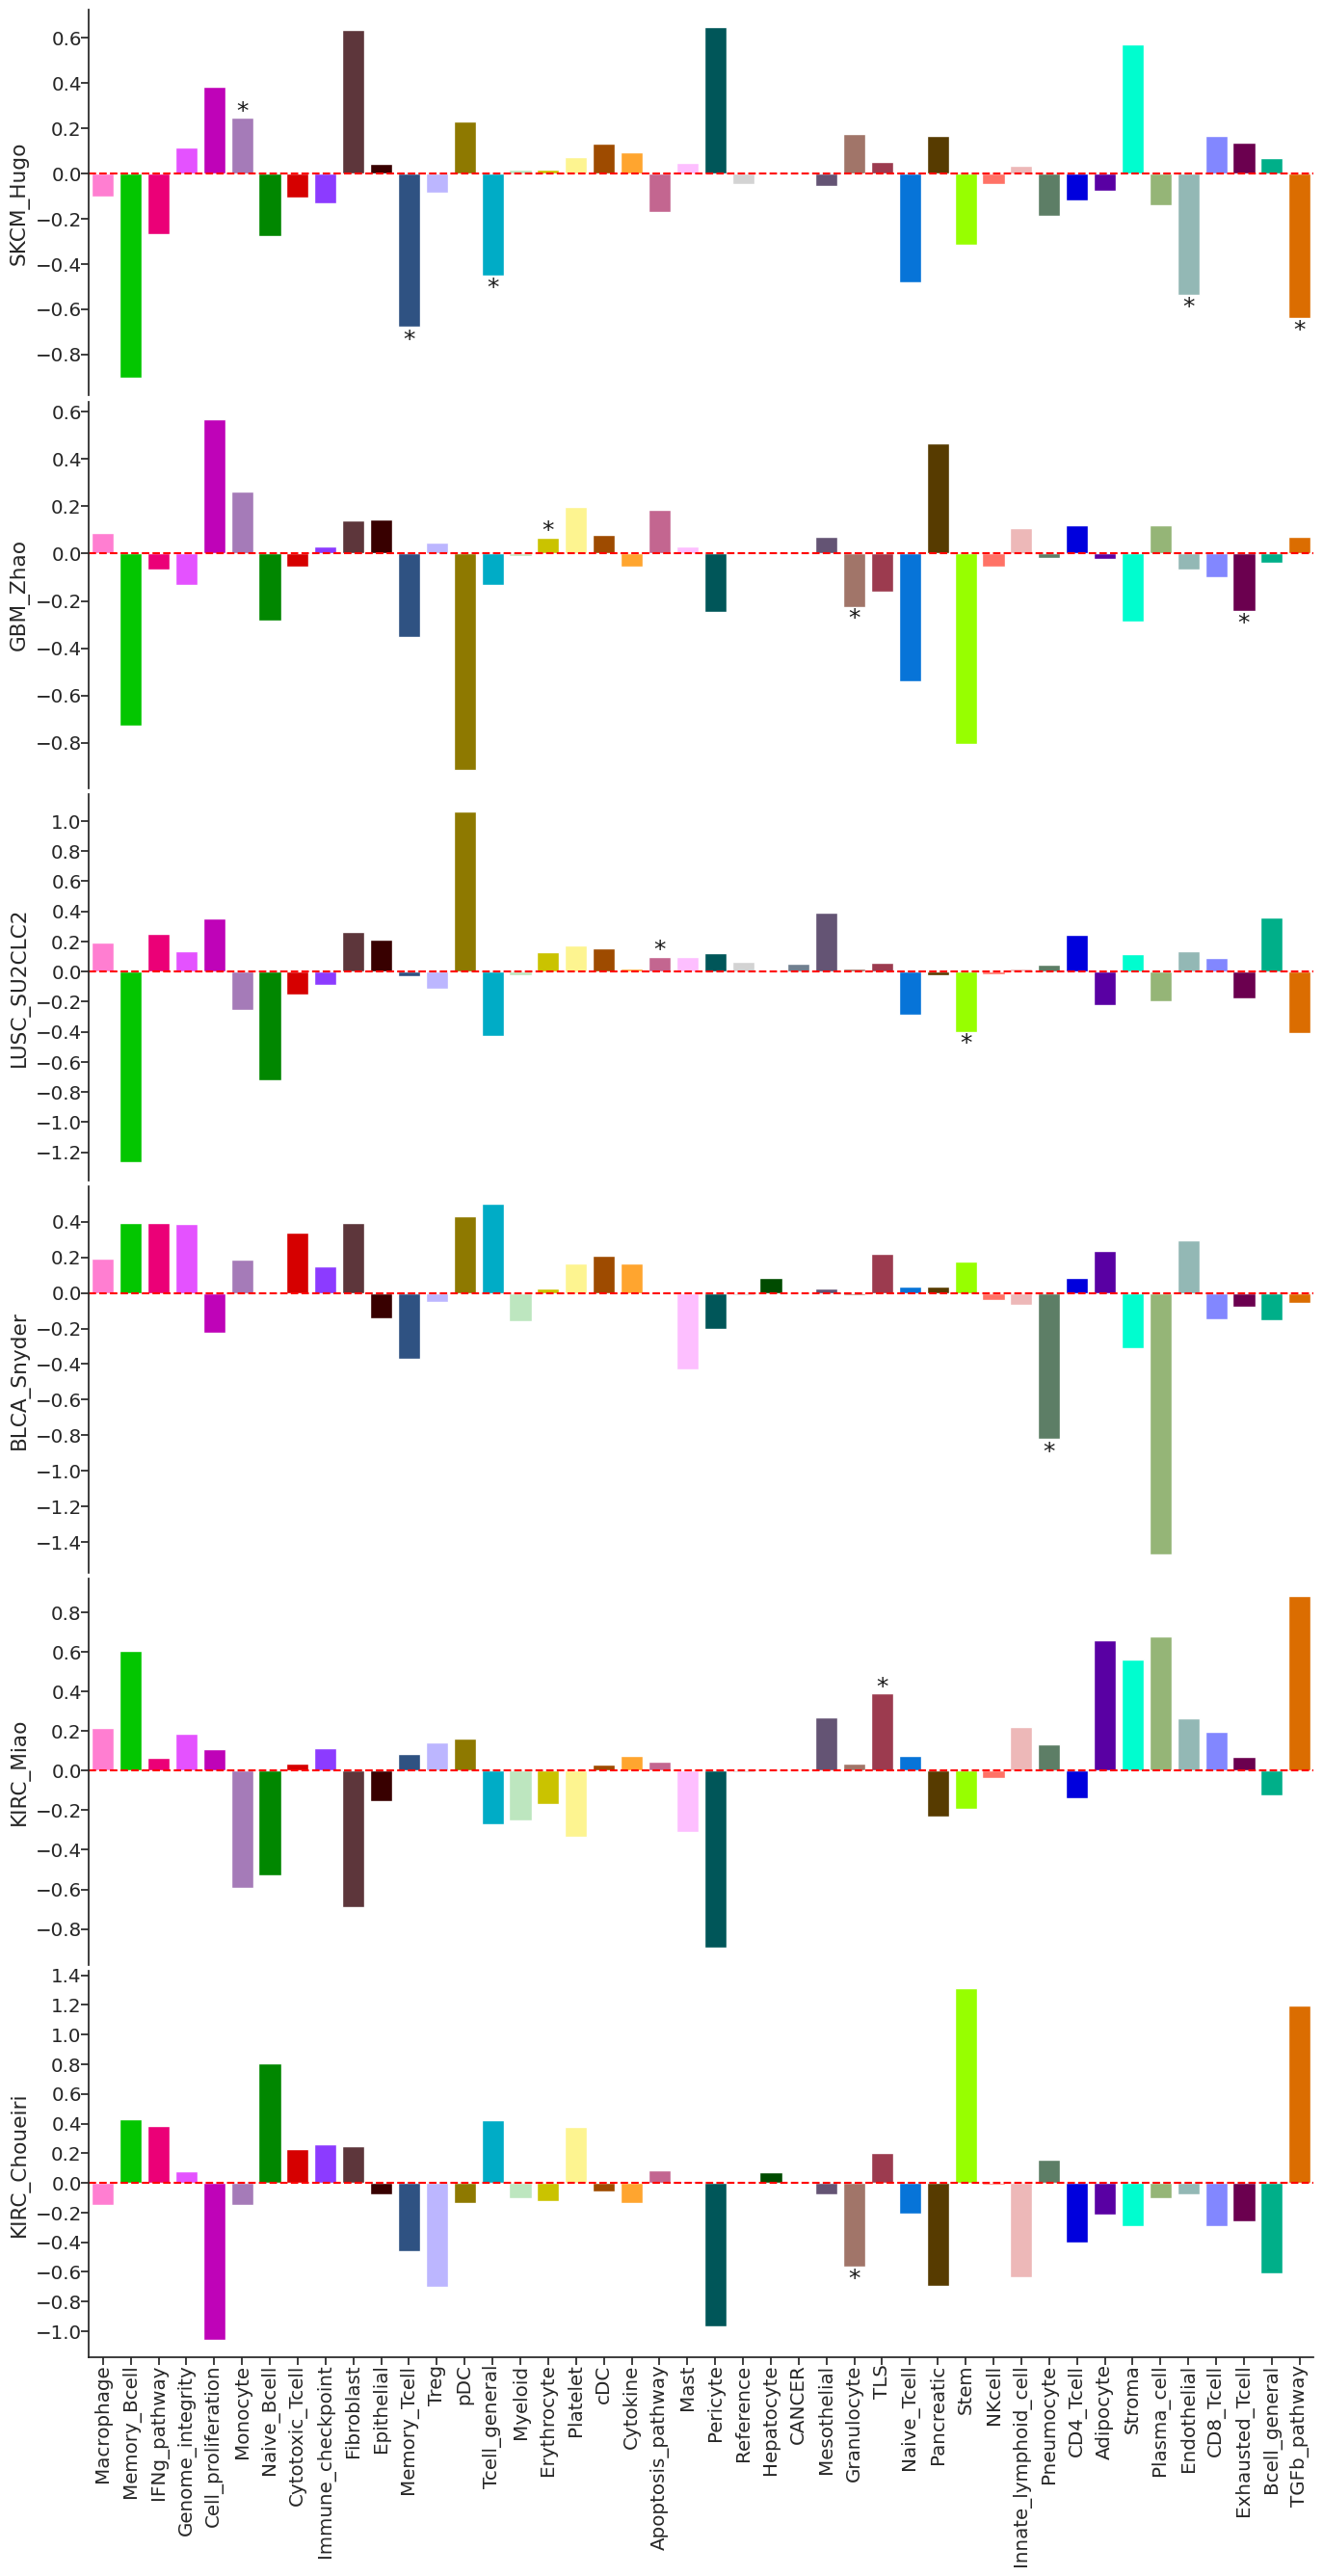

In [41]:
scohort = size_map[size_map=='small'].index
df1 = df[df.cohort.isin(scohort)]

feature_color = CONCEPT_palette

# 假设数据有 'cohort', 'concept', 'gfc', 'p_value' 列
#cohorts = size_map.index #df1['cohort'].unique()

# 创建16个子图
fig, axes = plt.subplots(nrows=len(scohort), figsize = (14, len(scohort)*4.5), sharex=True)

for i, cohort in enumerate(scohort):  # 确保只有16个子图

    #fig, ax = plt.subplots(figsize=(10, 4), sharex=False, sharey=False)
    ax = axes[i]

    cohort_data = df1[df1['cohort'] == cohort]
    
    # 按照gfc排序
    #cohort_data = cohort_data.sort_values(by=fc)
    cohort_data = cohort_data.set_index('concept').loc[order].reset_index()
    
    # 绘制散点图
    for index, row in cohort_data.iterrows():
        
        bar = ax.bar(row['concept'], row[fc], color=feature_color.get(row['concept'], '#000000'), ) #marker=shape, s=100
        if row[p] < 0.05:
            height = bar[0].get_height()
            if height > 0:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height-height/100),
                            ha='center', fontsize=18, color='k')
            else:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height+height/100),
                            ha='center',va='top', fontsize=18, color='k')
                
    # 红色虚线表示gfc为0的情况
    ax.axhline(0, color='red', linestyle='--')
    
    ax.set_ylabel(cohort)
    ax.set_xlim(-0.5, len(cohort_data) - 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

    if i == len(scohort)-1:
        ax.tick_params(axis='both', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        ax.set_xticklabels(order, rotation=90)

    else:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='y', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        # ax.set_xticklabels([])
        # ax.set_xticks(range(len(cohort_data)))
        ax.set_xticklabels([])
        
        #ax.set_ylim(-abs(cohort_data[fc].min())+0.1, cohort_data[fc].max()-0.02)
    # 调整布局

plt.tight_layout(h_pad=0.1)
fig.savefig('./gfc_bar_small_cohort.svg',bbox_inches ='tight')

In [42]:
df

,concept,u_stat,p_value,fc_sub,fc_fold,gfc,pbc_p_value,pbc,ev,cohort,Lineage,Lineage_order
0,CANCER,7332.5,4.353145e-01,2.086163e-07,1.000000,5.960464e-07,3.523706e-01,0.054061,0.002818,BLCA_IMVigor210,Functional_group,4
1,Bcell_general,8512.0,2.679840e-01,-3.239208e-02,0.850755,-2.338138e-01,4.340469e-01,-0.045484,0.002105,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0
2,Memory_Bcell,8049.0,7.143388e-01,-3.451377e-02,0.931391,-1.025972e-01,7.642610e-01,-0.017444,0.000304,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0
3,Naive_Bcell,7756.0,9.189782e-01,6.010842e-03,1.101072,1.386704e-01,3.832066e-01,-0.050694,0.002956,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0
4,Plasma_cell,8231.0,5.108069e-01,-2.154925e-02,0.947285,-7.821977e-02,4.079926e-01,-0.048106,0.002329,BLCA_IMVigor210,Lymphoid_lineage_Bcell,0
...,...,...,...,...,...,...,...,...,...,...,...,...
39,Cytokine,125814.5,4.159359e-02,1.214480e-02,1.022810,3.253800e-02,8.403425e-02,0.051352,0.002646,All,Functional_group,4
40,Cell_proliferation,103615.0,1.419260e-10,4.915091e-02,1.135438,1.832489e-01,1.302582e-10,0.189413,0.035230,All,Functional_group,4
41,TLS,125659.0,3.861955e-02,2.111253e-02,1.060400,8.460832e-02,2.972961e-01,0.030991,0.000952,All,Functional_group,4
42,Genome_integrity,122550.0,7.337985e-03,5.737719e-02,1.125925,1.711111e-01,7.860426e-03,0.078930,0.006191,All,Functional_group,4


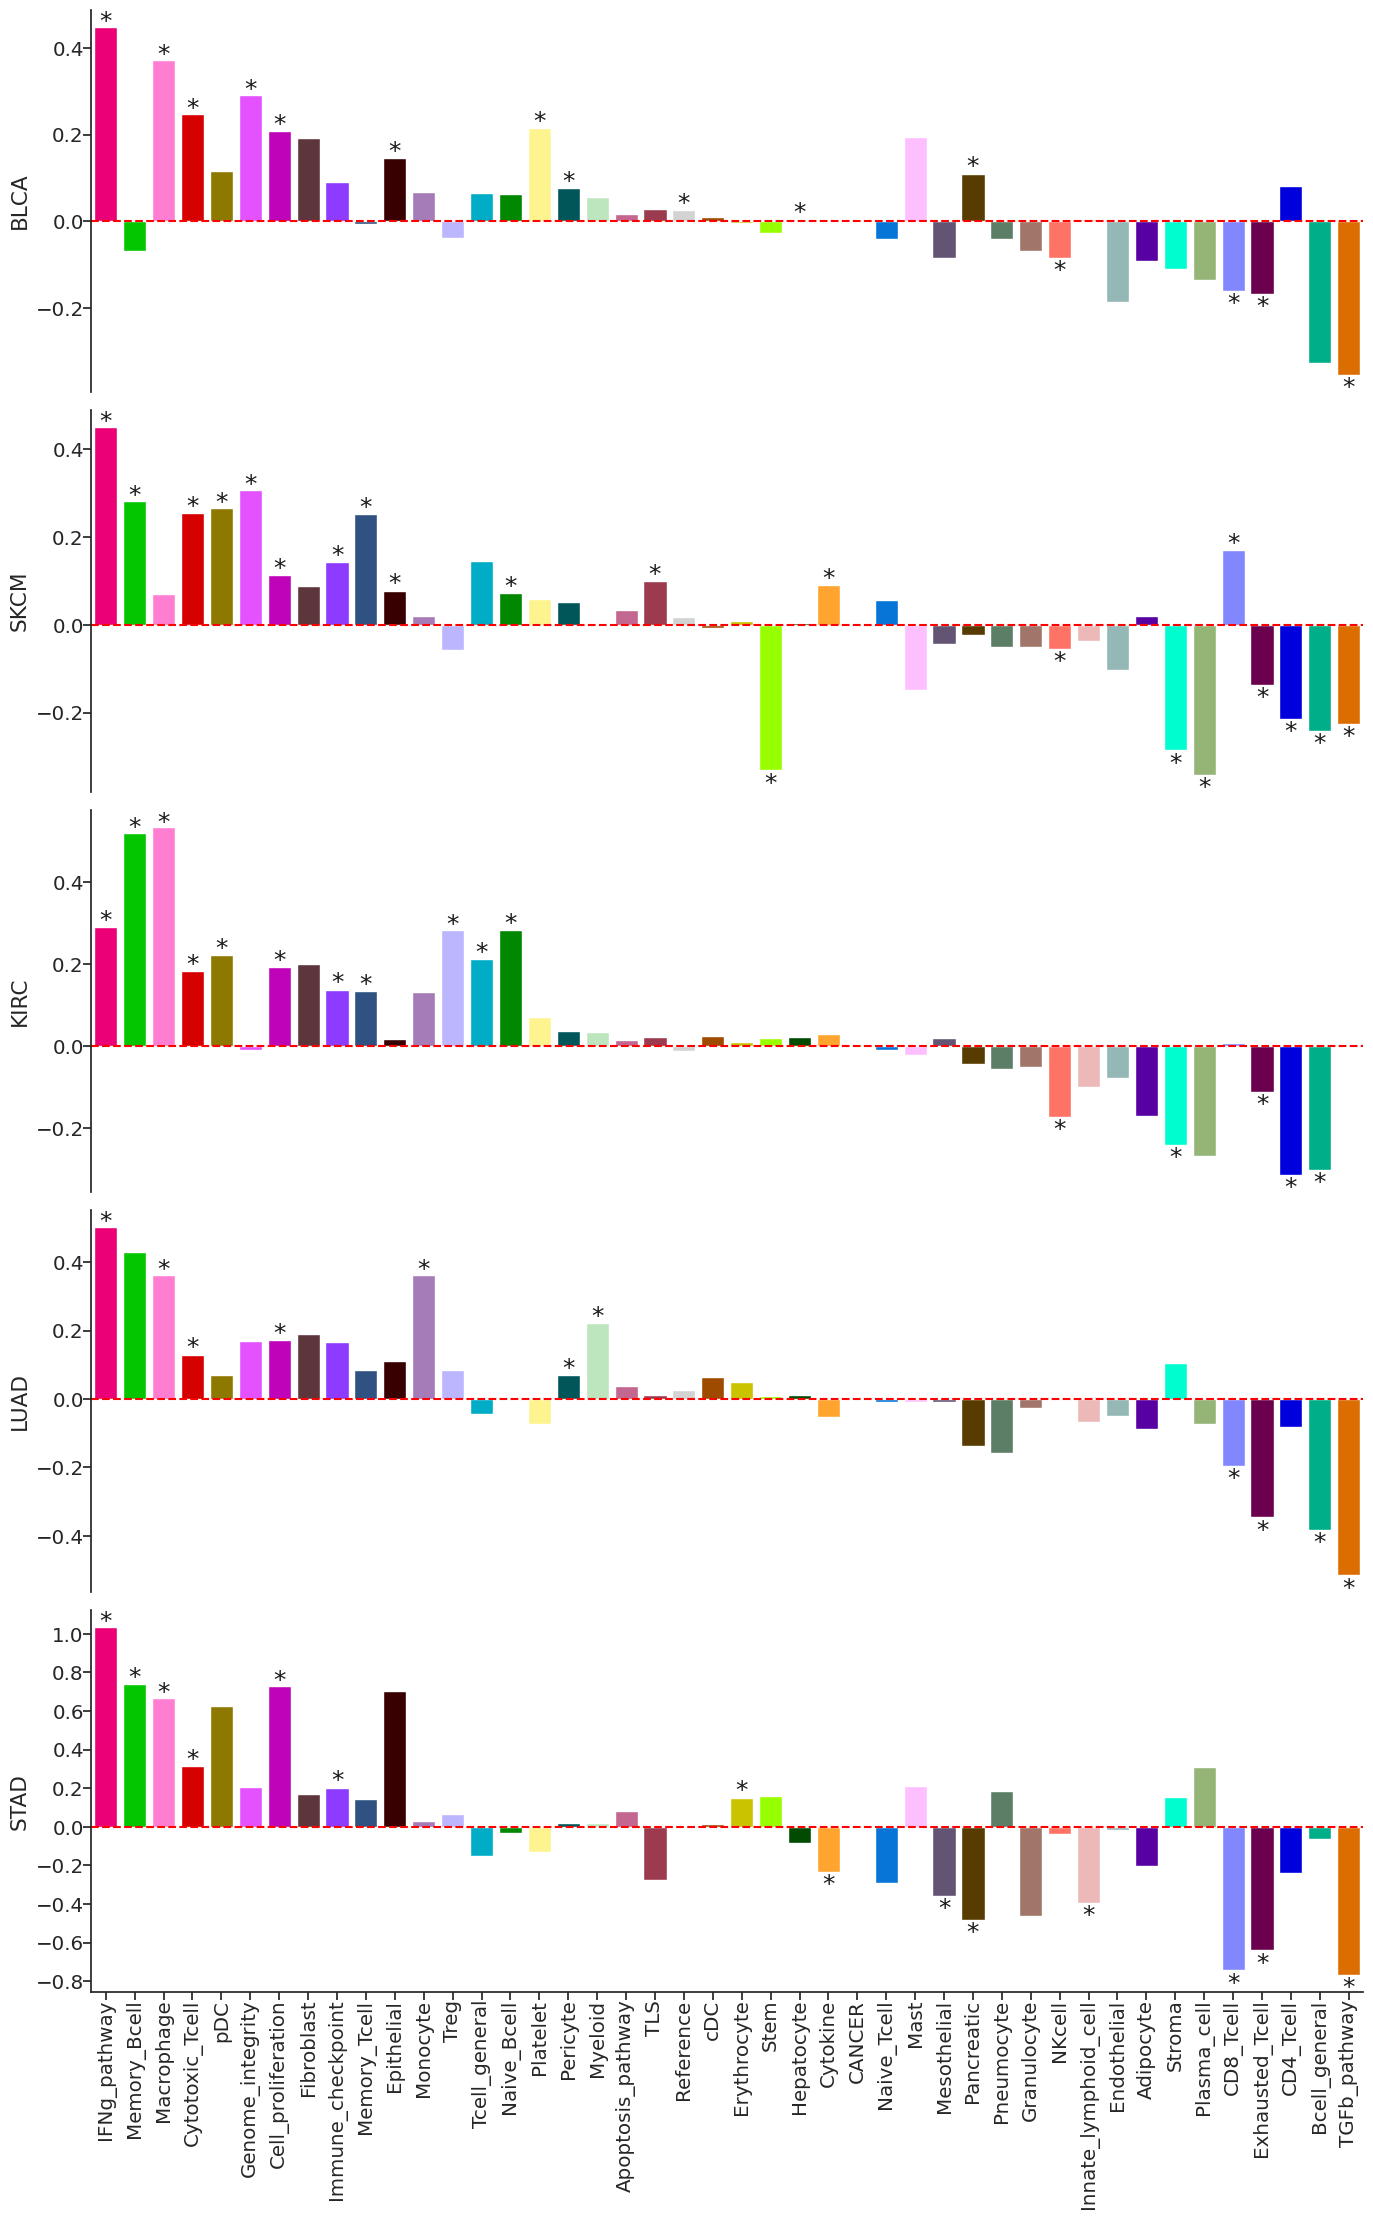

In [43]:
scohort = cancer_group
df1 = df[df.cohort.isin(scohort)]
order = df1.groupby('concept')[fc].median().sort_values(ascending=False).index

feature_color = CONCEPT_palette

# 假设数据有 'cohort', 'concept', 'gfc', 'p_value' 列
#cohorts = size_map.index #df1['cohort'].unique()

# 创建16个子图
fig, axes = plt.subplots(nrows=len(scohort), figsize = (14, len(scohort)*4.5), sharex=True)

for i, cohort in enumerate(scohort):  # 确保只有16个子图

    #fig, ax = plt.subplots(figsize=(10, 4), sharex=False, sharey=False)
    ax = axes[i]

    cohort_data = df1[df1['cohort'] == cohort]
    
    # 按照gfc排序
    #cohort_data = cohort_data.sort_values(by=fc)
    cohort_data = cohort_data.set_index('concept').loc[order].reset_index()
    
    # 绘制散点图
    for index, row in cohort_data.iterrows():
        
        bar = ax.bar(row['concept'], row[fc], color=feature_color.get(row['concept'], '#000000'), ) #marker=shape, s=100
        if row[p] < 0.05:
            height = bar[0].get_height()
            if height > 0:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height-height/100),
                            ha='center', fontsize=18, color='k')
            else:
                ax.annotate('*', (bar[0].get_x() + bar[0].get_width() / 2, height+height/100),
                            ha='center',va='top', fontsize=18, color='k')
                
    # 红色虚线表示gfc为0的情况
    ax.axhline(0, color='red', linestyle='--')
    
    ax.set_ylabel(cohort)
    ax.set_xlim(-0.5, len(cohort_data) - 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

    if i == len(scohort)-1:
        ax.tick_params(axis='both', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        ax.set_xticklabels(order, rotation=90)

    else:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='y', bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        # ax.set_xticklabels([])
        # ax.set_xticks(range(len(cohort_data)))
        ax.set_xticklabels([])
        
        #ax.set_ylim(-abs(cohort_data[fc].min())+0.1, cohort_data[fc].max()-0.02)
    # 调整布局

plt.tight_layout(h_pad=0.1)
fig.savefig('./gfc_bar_cancer_group.svg',bbox_inches ='tight')

In [44]:
dfcelltype = dfc
df_label = dfl

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:1.833e-04 U_stat=5.189e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:7.751e-06 U_stat=4.937e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:5.425e-12 U_stat=3.635e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:7.782e-11 U_stat=1.655e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:1.726e-12 U_stat=1.241e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val

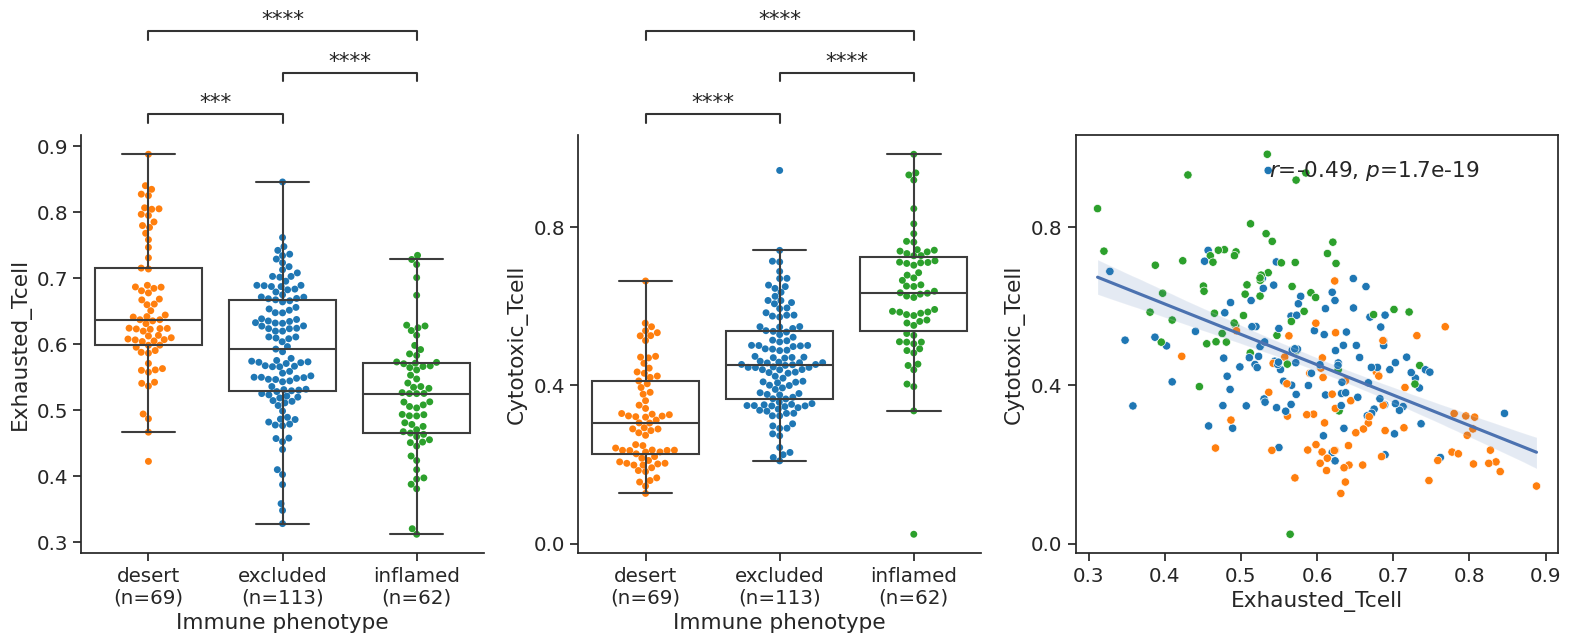

In [45]:
IMVigor210 = df_label[df_label.cohort == 'BLCA_IMVigor210']

x = 'Immune phenotype'
y1 = 'Exhausted_Tcell'
y2 = 'Cytotoxic_Tcell'
x_order = ['desert', 'excluded', 'inflamed']
box_pairs = [('desert', 'excluded'), ('desert', 'inflamed'), ('excluded', 'inflamed')]
data = IMVigor210[[x]].join(dfcelltype[[y1,y2]])
size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[0], palette[2]]


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    # ax.set_xticklabels(
    #     x_order, 
    #     rotation=1, 
    #     ha="right",  
    #     rotation_mode="anchor")  # <====== HERE is the ke

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)


    
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(0.1))


fig.tight_layout()

fig.savefig('IMvigor210_score_phenotype.pdf')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

R
(n=68) vs. NR
(n=230): Mann-Whitney-Wilcoxon test two-sided, P_val:1.268e-04 U_stat=5.427e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

R
(n=68) vs. NR
(n=230): Mann-Whitney-Wilcoxon test two-sided, P_val:3.280e-02 U_stat=9.153e+03


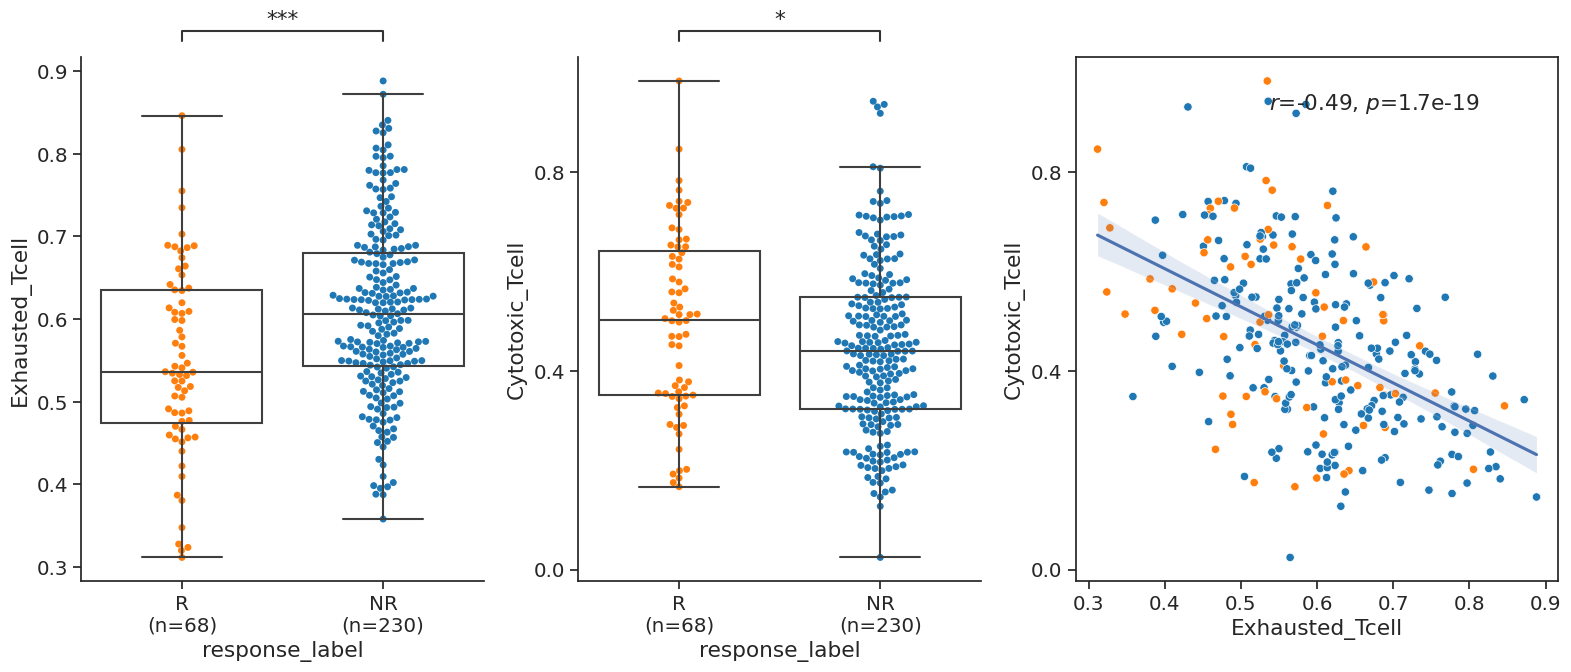

In [46]:
IMVigor210 = df_label[df_label.cohort == 'BLCA_IMVigor210']  #[df_label.cohort == 'BLCA_IMVigor210']

x = 'response_label'
y1 = 'Exhausted_Tcell' #'', ''
y2 = 'Cytotoxic_Tcell'

x_order = ['R', 'NR']
box_pairs = [('R', 'NR')]
data = IMVigor210[[x]].join(dfcelltype[[y1,y2]])
size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[0], palette[2]]


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    # ax.set_xticklabels(
    #     x_order, 
    #     rotation=1, 
    #     ha="right",  
    #     rotation_mode="anchor")  # <====== HERE is the ke

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)


    
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(0.1))


fig.tight_layout()

In [112]:
cohort = df_label[df_label.cohort == 'LUAD_SU2CLC1']
x = 'Immune phenotype'

dfp = pd.read_csv('./SU2CLC1_phenotype.tsv', index_col=0, sep='\t')
cohort[x] = cohort.Sample_id.map(dfp.Phenotype)

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[0], palette[2]]
sns.palettes.color_palette('tab10', 4)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=24) vs. activated
(n=36): Mann-Whitney-Wilcoxon test two-sided, P_val:2.077e-01 U_stat=5.160e+02
activated
(n=36) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon test two-sided, P_val:5.248e-05 U_stat=1.160e+03
desert
(n=24) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon test two-sided, P_val:4.151e-05 U_stat=8.120e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=24) vs. activated
(n=36): Mann-Whitney-Wilcoxon test two-sided, P_val:3.939e-01 U_stat=3.750e+02
activated
(n=36) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon test two-sided, P_val:6.196e-04 U_stat=1.098e+03
desert
(n=24) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon t

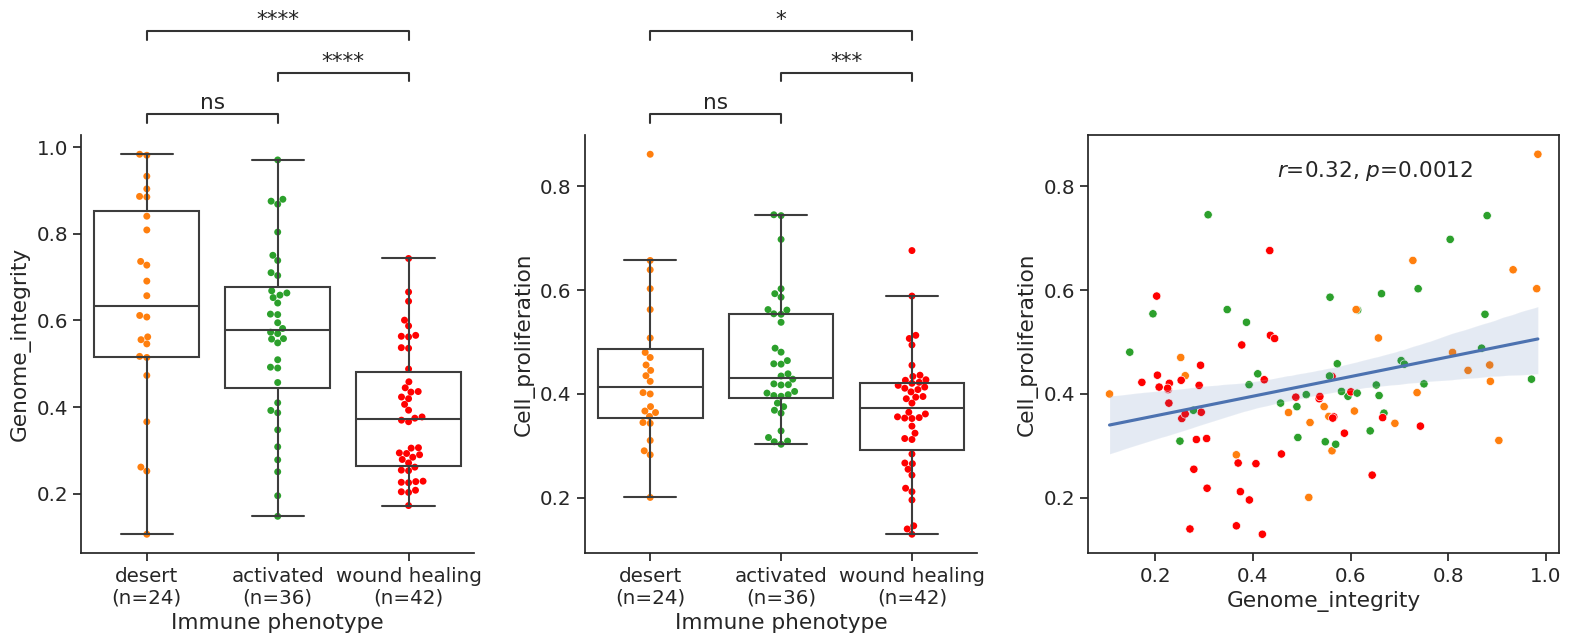

In [113]:
y1 = 'Genome_integrity'
y2 = 'Cell_proliferation'
x_order = [ 'desert','activated','wound healing']
box_pairs = [('desert', 'wound healing'), ('desert', 'activated'), ('wound healing', 'activated')]
data = cohort[[x]].join(dfcelltype[[y1,y2]])
size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [ palette[1], palette[2], 'red']


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    # ax.set_xticklabels(
    #     x_order, 
    #     rotation=1, 
    #     ha="right",  
    #     rotation_mode="anchor")  # <====== HERE is the ke

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

    
fig.tight_layout()

fig.savefig('SU2CLC1_score_phenotype_wound_healiing.pdf')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=24) vs. activated
(n=36): Mann-Whitney-Wilcoxon test two-sided, P_val:1.156e-04 U_stat=6.880e+02
activated
(n=36) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon test two-sided, P_val:1.545e-07 U_stat=2.320e+02
desert
(n=24) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon test two-sided, P_val:7.736e-02 U_stat=3.710e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=24) vs. activated
(n=36): Mann-Whitney-Wilcoxon test two-sided, P_val:7.165e-07 U_stat=1.030e+02
activated
(n=36) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon test two-sided, P_val:6.149e-07 U_stat=1.254e+03
desert
(n=24) vs. wound healing
(n=42): Mann-Whitney-Wilcoxon t

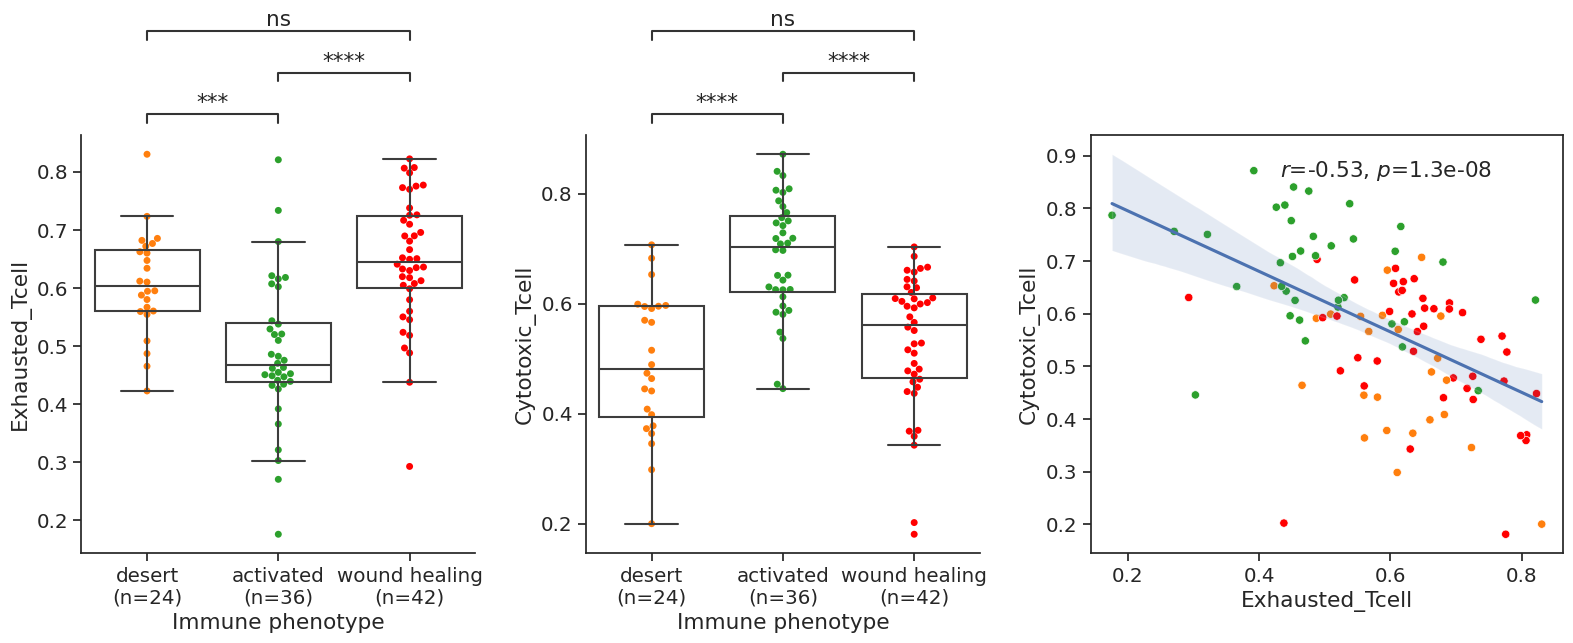

In [114]:
y1 = 'Exhausted_Tcell' #'', ''
y2 = 'Cytotoxic_Tcell'
x_order = [  'desert','activated', 'wound healing']
box_pairs = [('desert', 'wound healing'), ('desert', 'activated'), ('wound healing', 'activated')]
data = cohort[[x]].join(dfcelltype[[y1,y2]])
size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[2], 'red']


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    # ax.set_xticklabels(
    #     x_order, 
    #     rotation=1, 
    #     ha="right",  
    #     rotation_mode="anchor")  # <====== HERE is the ke
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    
fig.tight_layout()

fig.savefig('SU2CLC1_score_phenotype_ex_cyc.pdf')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

R
(n=38) vs. NR
(n=64): Mann-Whitney-Wilcoxon test two-sided, P_val:1.276e-04 U_stat=6.620e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

R
(n=38) vs. NR
(n=64): Mann-Whitney-Wilcoxon test two-sided, P_val:1.647e-02 U_stat=1.563e+03


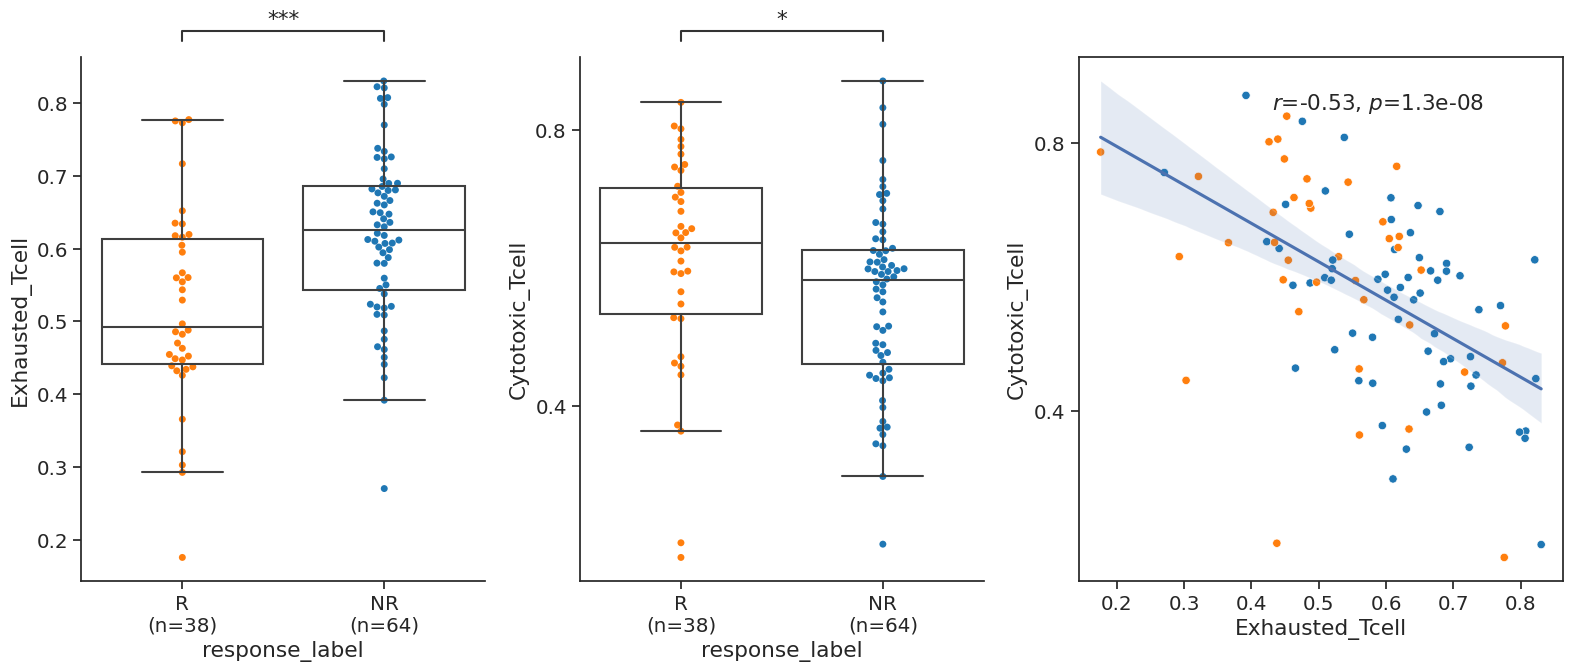

In [115]:
IMVigor210 = df_label[df_label.cohort == 'LUAD_SU2CLC1']  #[df_label.cohort == 'BLCA_IMVigor210']

x = 'response_label'
y1 = 'Exhausted_Tcell' #'', ''
y2 = 'Cytotoxic_Tcell'

# y1 = 'Exhausted_Tcell'
# y2 = 'Cytotoxic_Tcell'

x_order = ['R', 'NR']
box_pairs = [('R', 'NR')]
data = IMVigor210[[x]].join(dfcelltype[[y1,y2]])
size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[0], palette[2]]


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    # ax.set_xticklabels(
    #     x_order, 
    #     rotation=1, 
    #     ha="right",  
    #     rotation_mode="anchor")  # <====== HERE is the ke

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)


    
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(0.1))


fig.tight_layout()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

R
(n=38) vs. NR
(n=64): Mann-Whitney-Wilcoxon test two-sided, P_val:3.664e-01 U_stat=1.347e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

R
(n=38) vs. NR
(n=64): Mann-Whitney-Wilcoxon test two-sided, P_val:3.158e-03 U_stat=1.643e+03


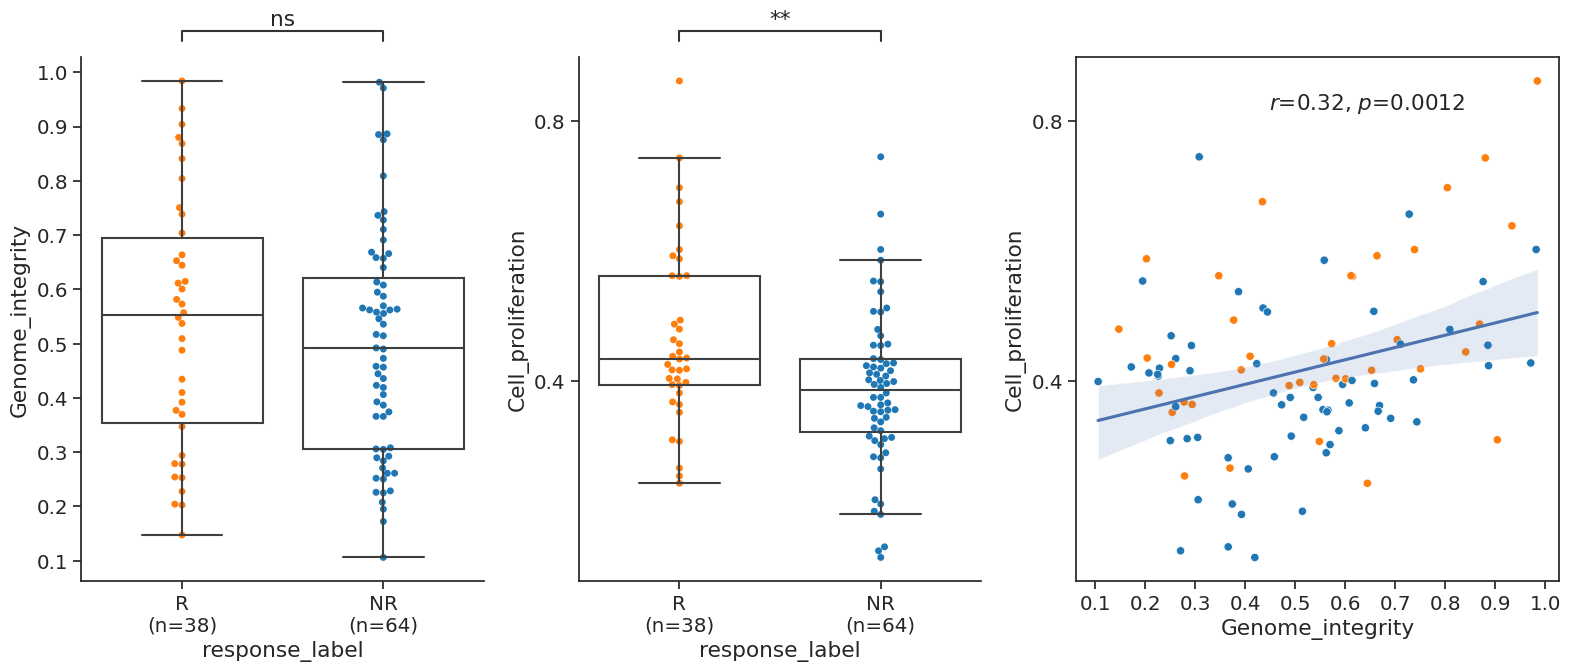

In [116]:
IMVigor210 = df_label[df_label.cohort == 'LUAD_SU2CLC1']  #[df_label.cohort == 'BLCA_IMVigor210']

x = 'response_label'
y1 = 'Genome_integrity'
y2 = 'Cell_proliferation'

# y1 = 'Exhausted_Tcell'
# y2 = 'Cytotoxic_Tcell'

x_order = ['R', 'NR']
box_pairs = [('R', 'NR')]
data = IMVigor210[[x]].join(dfcelltype[[y1,y2]])
size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[0], palette[2]]


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    # ax.set_xticklabels(
    #     x_order, 
    #     rotation=1, 
    #     ha="right",  
    #     rotation_mode="anchor")  # <====== HERE is the ke

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)


    
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

fig.tight_layout()